# Toxic Comments Classification - Comprehensive Analysis

This notebook performs detailed data analysis and compares three machine learning algorithms (Logistic Regression, Random Forest, and Multi-Layer Perceptron) for multi-label toxic comment classification using both TF-IDF and spaCy word embeddings.

## Objectives
1. Perform detailed data analysis (sentences, tokens per class, imbalance analysis, most common words)
2. Implement and compare 3 ML algorithms with TF-IDF and Word Embeddings
3. Evaluate using comprehensive metrics (Accuracy, F1-score, Recall, Precision, AUC)
4. Compare feature extraction methods and algorithms


## 1. Import Libraries


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Utilities
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import string
from collections import Counter
import spacy

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix,
    hamming_loss
)
from sklearn.preprocessing import MultiLabelBinarizer

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import set_random_seed

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
set_random_seed(42)

print("Required libraries imported successfully!")


Required libraries imported successfully!


## 2. Load and Explore Dataset


In [2]:
# Load training dataset
train_df = pd.read_csv('./dataset/train/train.csv')

print(f"Dataset shape:  {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")

print(f"\nDisplay first few rows of the training data:")

train_df.head(n=10)

Dataset shape:  (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Display first few rows of the training data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
# Check for missing values
print("Missing values:")
print(train_df.isnull().sum())
print(f"\nTotal missing values in the training dataframe: {train_df.isnull().sum().sum()}")

# Basic statistics
print("\nDataset info:")
print(train_df.info())

print("\nBasic statistics:")
train_df.describe()


Missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Total missing values in the training dataframe: 0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None

Basic statistics:


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Data Analysis

### 3.1 Class Distribution and Imbalance Analysis


Class Distribution:
                 Count  Percentage
toxic          15294.0    9.584448
obscene         8449.0    5.294822
insult          7877.0    4.936361
severe_toxic    1595.0    0.999555
identity_hate   1405.0    0.880486
threat           478.0    0.299553

Total samples: 159571


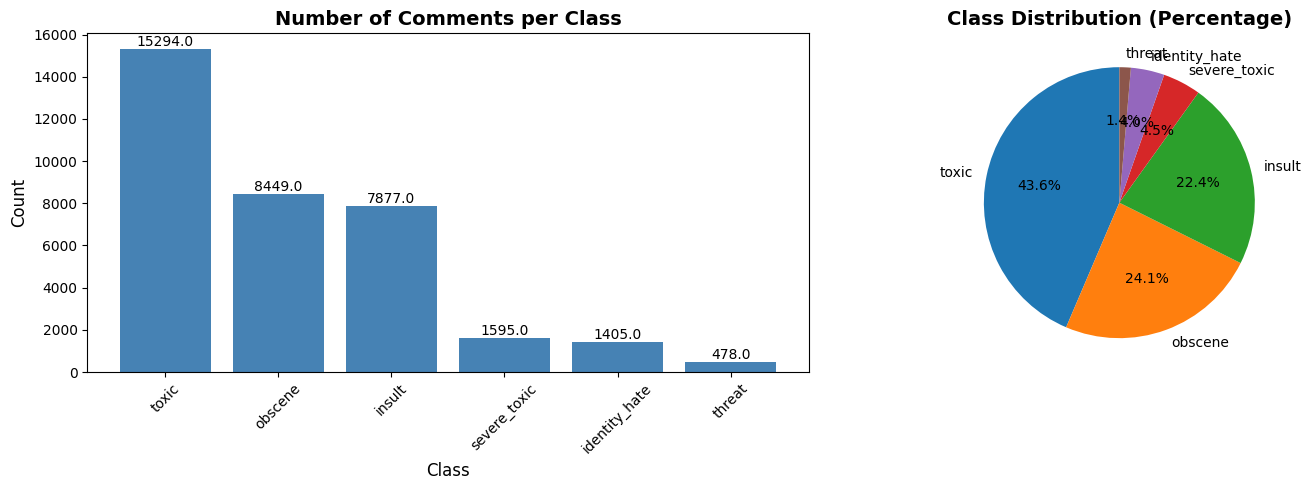


Multi-label Distribution:
Number of labels per comment:
  0 labels: 143,346 (89.83%)
  1 labels: 6,360 (3.99%)
  2 labels: 3,480 (2.18%)
  3 labels: 4,209 (2.64%)
  4 labels: 1,760 (1.10%)
  5 labels: 385 (0.24%)
  6 labels: 31 (0.02%)


In [4]:
# Define target columns
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calculate class distribution
class_distribution = {}
total_samples = len(train_df)

for col in target_cols:
    count = train_df[col].sum()
    percentage = (count / total_samples) * 100
    class_distribution[col] = {
        'count': count,
        'percentage': percentage
    }

# Create DataFrame for better visualization
dist_df = pd.DataFrame(class_distribution).T
dist_df.columns = ['Count', 'Percentage']
dist_df = dist_df.sort_values('Count', ascending=False)

print("Class Distribution:")
print(dist_df)
print(f"\nTotal samples: {total_samples}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

# Bar chart
axes[0].bar(dist_df.index, dist_df['Count'], color='steelblue')
axes[0].set_title('Number of Comments per Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(dist_df['Count']):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Pie chart
axes[1].pie(dist_df['Count'], labels=dist_df.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for multi-label distribution
train_df['num_labels'] = train_df[target_cols].sum(axis=1)
multi_label_dist = train_df['num_labels'].value_counts().sort_index()


print("\nMulti-label Distribution:")
print("Number of labels per comment:")
for num_labels, count in multi_label_dist.items():
    percentage = (count / total_samples) * 100
    print(f"  {int(num_labels)} labels: {count:,} ({percentage:.2f}%)")

### 3.2 Sentences and Tokens Analysis per Class


Sentences and Tokens Analysis per Class:
               Number of Sentences  Total Tokens  Avg Tokens per Comment
toxic                      15294.0      775533.0                   50.71
severe_toxic                1595.0      119959.0                   75.21
obscene                     8449.0      414853.0                   49.10
threat                       478.0       26257.0                   54.93
insult                      7877.0      376942.0                   47.85
identity_hate               1405.0       72530.0                   51.62


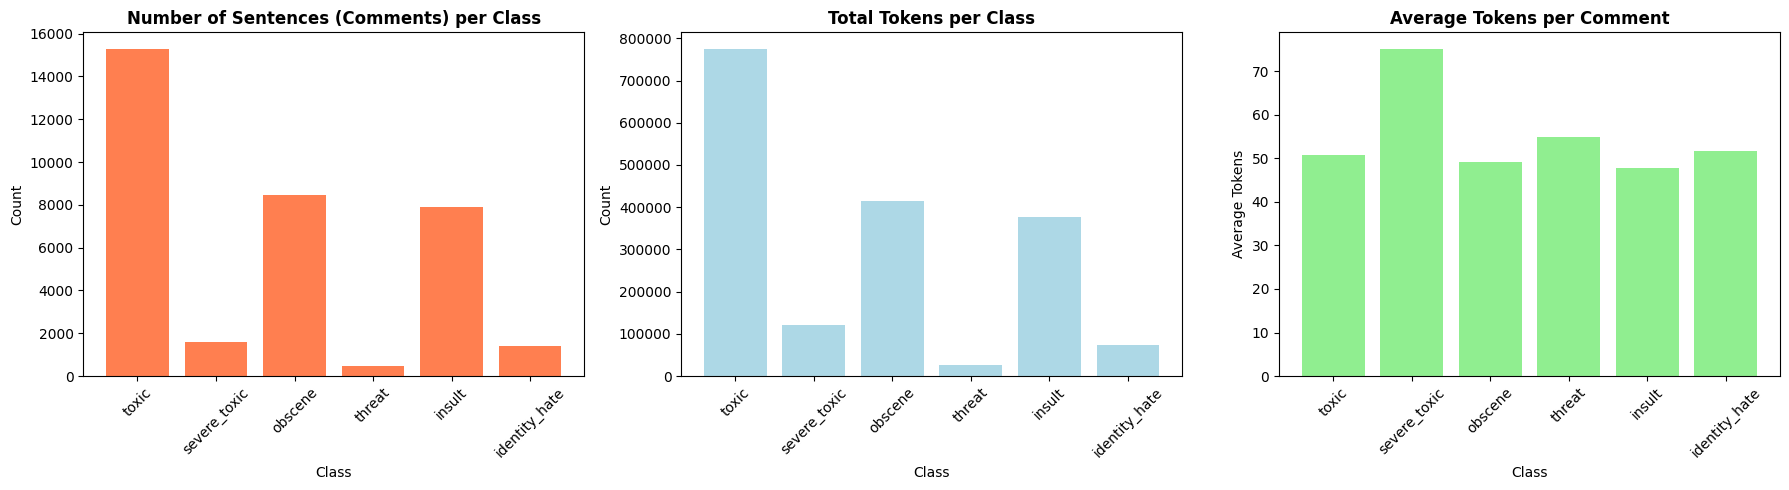


Imbalance Analysis:
Ratio of majority class (neutral) to each toxic class:
  toxic: 9.43:1 (neutral:toxic)
  severe_toxic: 99.04:1 (neutral:severe_toxic)
  obscene: 17.89:1 (neutral:obscene)
  threat: 332.83:1 (neutral:threat)
  insult: 19.26:1 (neutral:insult)
  identity_hate: 112.57:1 (neutral:identity_hate)


In [5]:
# Text preprocessing function for tokenization
def preprocess_text(text):
    """Basic text preprocessing for tokens (words) counting"""
    if pd.isna(text):
        return []
    # Convert to lowercase (text normalization)
    text = str(text).lower()
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Split into tokens
    tokens = text.split()
    return tokens

# Analyze sentences and tokens per class
class_analysis = {}

for col in target_cols:
    # Get comments for this class (where label = 1)
    class_comments = train_df[train_df[col] == 1]['comment_text']
    # Count sentences (comments)
    num_sentences = len(class_comments)
    
    # count tokens
    all_tokens = []
    for comment in class_comments:
        tokens = preprocess_text(comment)
        all_tokens.extend(tokens)
    
    total_tokens = len(all_tokens)
    avg_tokens_per_comment = total_tokens / num_sentences if num_sentences > 0 else 0
    
    class_analysis[col] = {
        'num_sentences': num_sentences,
        'total_tokens': total_tokens,
        'avg_tokens_per_comment': avg_tokens_per_comment
    }

# Create DataFrame from the dictionary
analysis_df = pd.DataFrame(class_analysis).T
analysis_df.columns = ['Number of Sentences', 'Total Tokens', 'Avg Tokens per Comment']
analysis_df = analysis_df.round(2)

print("Sentences and Tokens Analysis per Class:")
print(analysis_df)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Number of sentences
axes[0].bar(analysis_df.index, analysis_df['Number of Sentences'], color='coral')
axes[0].set_title('Number of Sentences (Comments) per Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Total tokens
axes[1].bar(analysis_df.index, analysis_df['Total Tokens'], color='lightblue')
axes[1].set_title('Total Tokens per Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=10)
axes[1].set_ylabel('Count', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Average tokens per comment
axes[2].bar(analysis_df.index, analysis_df['Avg Tokens per Comment'], color='lightgreen')
axes[2].set_title('Average Tokens per Comment', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Class', fontsize=10)
axes[2].set_ylabel('Average Tokens', fontsize=10)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Imbalance ratio analysis
print("\nImbalance Analysis:")
print("Ratio of majority class (neutral) to each toxic class:")
for col in target_cols:
    toxic_count = train_df[col].sum()
    neutral_count = total_samples - toxic_count
    ratio = neutral_count / toxic_count if toxic_count > 0 else float('inf')
    print(f"  {col}: {ratio:.2f}:1 (neutral:{col})")


### 3.3 Most Common Words Analysis per Class


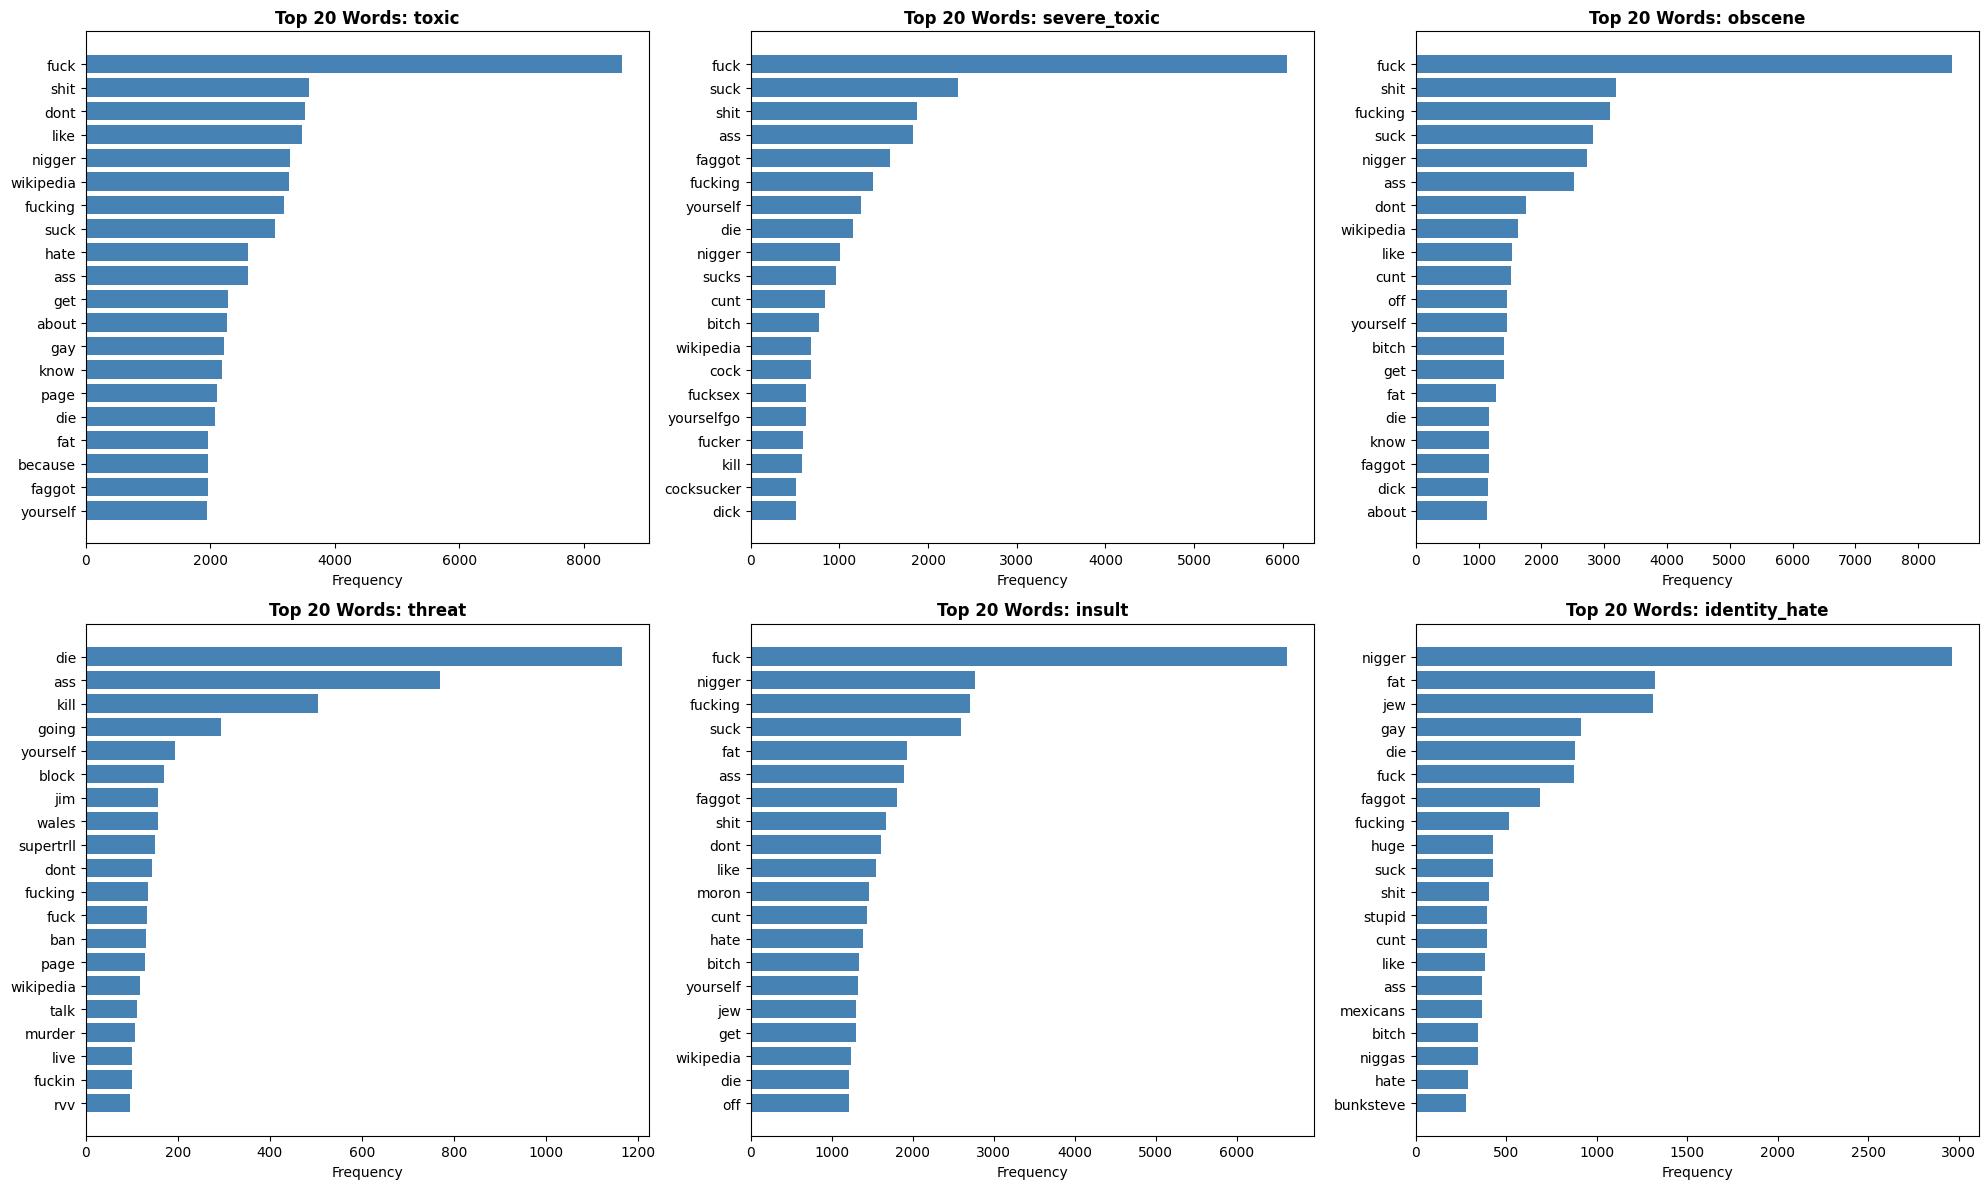



Top 20 words for 'toxic' class:
	fuck: 8614
	shit: 3587
	dont: 3528
	like: 3477
	nigger: 3289
	wikipedia: 3262
	fucking: 3193
	suck: 3036
	hate: 2614
	ass: 2601
	get: 2283
	about: 2265
	gay: 2223
	know: 2182
	page: 2116
	die: 2077
	fat: 1967
	because: 1957
	faggot: 1957
	yourself: 1941


Top 20 words for 'severe_toxic' class:
	fuck: 6047
	suck: 2341
	shit: 1878
	ass: 1828
	faggot: 1570
	fucking: 1374
	yourself: 1239
	die: 1155
	nigger: 1011
	sucks: 961
	cunt: 833
	bitch: 765
	wikipedia: 681
	cock: 679
	fucksex: 624
	yourselfgo: 621
	fucker: 585
	kill: 580
	cocksucker: 508
	dick: 508


Top 20 words for 'obscene' class:
	fuck: 8539
	shit: 3187
	fucking: 3098
	suck: 2823
	nigger: 2721
	ass: 2520
	dont: 1749
	wikipedia: 1636
	like: 1527
	cunt: 1520
	off: 1452
	yourself: 1450
	bitch: 1400
	get: 1399
	fat: 1281
	die: 1169
	know: 1169
	faggot: 1163
	dick: 1153
	about: 1140


Top 20 words for 'threat' class:
	die: 1165
	ass: 769
	kill: 504
	going: 294
	yourself: 193
	block: 170
	jim: 158
	wa

In [6]:
# text preprocessing for word analysis
def preprocess_for_analysis(text):
    """Preprocess text for word frequency analysis"""
    if pd.isna(text):
        return []
    # Convert to lowercase
    text = str(text).lower()
    # Remove URLs and links from the comments text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Split into tokens and filter out very short words
    tokens = [word for word in text.split() if len(word) > 2]
    return tokens

#  Common stopwords (basic list)
stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                 'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
                 'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
                 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that',
                 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they',
                 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her',
                 'its', 'our', 'their', 'what', 'which', 'who', 'whom', 'whose',
                 'where', 'when', 'why', 'how', 'all', 'each', 'every', 'both',
                 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
                 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 'just', 'now', 'then', 'here', 'there', 'when', 'where', 'why'])

# Analyze most common words for each class
top_n = 20
class_words = {}

for col in target_cols:
    # Get comments for this class
    class_comments = train_df[train_df[col] == 1]['comment_text']
    
    # Collect all words
    all_words = []
    for comment in class_comments:
        tokens = preprocess_for_analysis(comment)
        # Filtering out stopwords
        tokens = [t for t in tokens if t not in stopwords]
        all_words.extend(tokens)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(top_n)

    class_words[col] = top_words

# Visualize top 20 words for each class
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, col in enumerate(target_cols):
    words, counts = zip(*class_words[col])
    axes[idx].barh(range(len(words)), counts, color='steelblue')
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_xlabel('Frequency', fontsize=10)
    axes[idx].set_title(f'Top {top_n} Words: {col}', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

for col in target_cols:
    words, count = zip(*class_words[col])
    print(f"\n\nTop {top_n} words for '{col}' class:")
    for word, count in zip(words, count): 
            print(f"\t{word}: {count}")

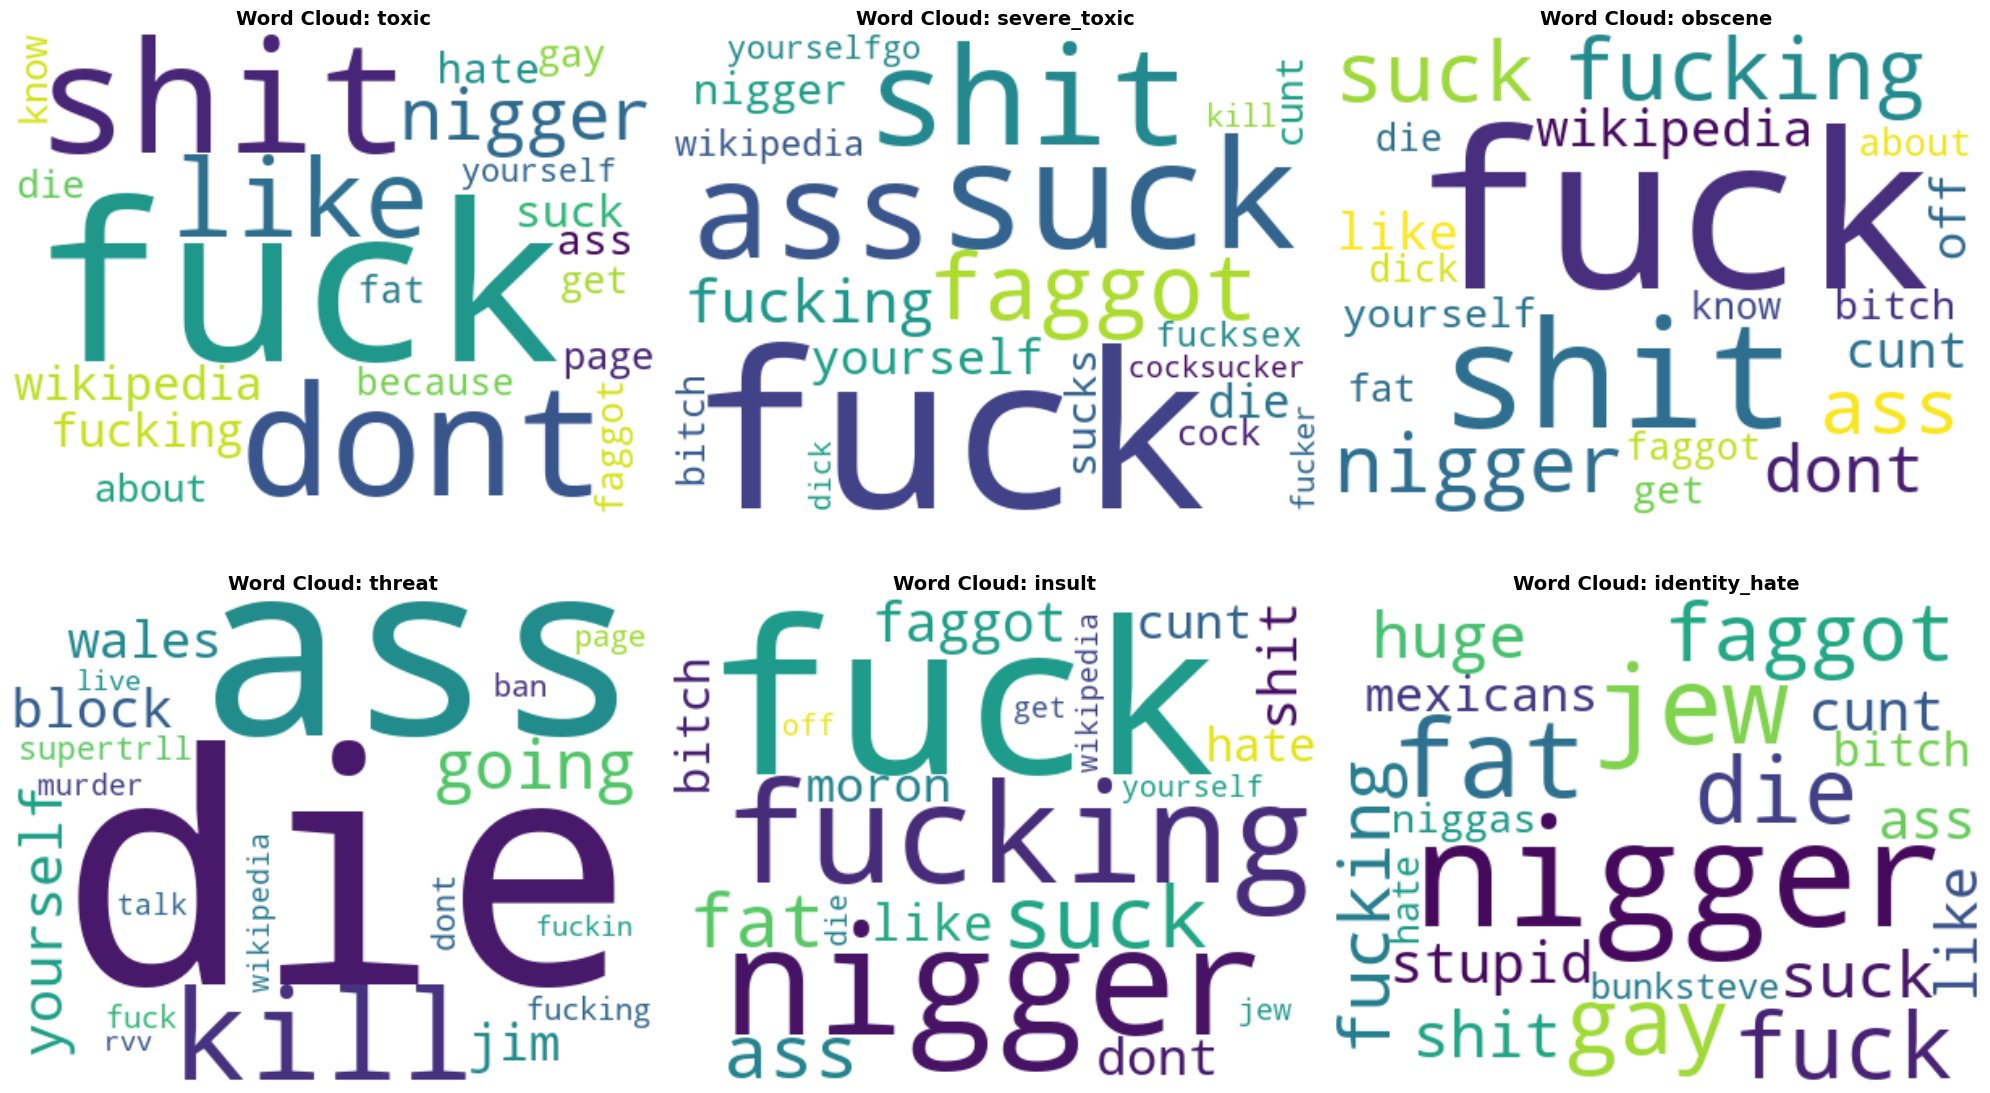

In [7]:
# Create word clouds for each class
try:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, col in enumerate(target_cols):
        # Prepare text for word cloud
        words_dict = dict(class_words[col])
        if words_dict:
            wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(words_dict)
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].axis('off')
            axes[idx].set_title(f'Word Cloud: {col}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Word cloud visualization skipped: {e}")

## 4. Feature Extraction

### 4.1 Text Preprocessing


In [8]:
# Text preprocessing function for ML models
def clean_text(text):
    """Clean text for feature extraction"""
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply preprocessing
train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)

# Prepare features and labels
X = train_df['cleaned_text']
y = train_df[target_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None  
)


print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training set size: 127656
Test set size: 31915

Training labels shape: (127656, 6)
Test labels shape: (31915, 6)


### 4.2 TF-IDF Vectorization


In [11]:
# Initialize TF-IDF Vectorizer
# Parameters used to initialize TF-IDF:
#  - max_features=10000: Limit vocabulary to top 10000 terms
# - stop_words='english': Remove common English stopwords
# - ngram_range=(1,2): Use both unigrams and bigrams
#  - min_df=2: Ignore terms that appear in less than 2 documents
#  - max_df=0.95: Ignore terms that appear in more than 95% of documents

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    lowercase=True
)

# Fit and transform training data
print("Fitting TF-IDF vectorizer on training data....")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f"TF-IDF training shape: {X_train_tfidf.shape}")

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"TF-IDF test shape: {X_test_tfidf.shape}")

print(f"\nVocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print("TF-IDF vectorization completed successfully!")

Fitting TF-IDF vectorizer on training data....
TF-IDF training shape: (127656, 10000)
TF-IDF test shape: (31915, 10000)

Vocabulary size: 10000
TF-IDF vectorization completed successfully!


### 4.3 spaCy Word Embeddings


In [9]:
# Loading spaCy model with pre-trained word vectors
# Try to load medium or large model, fallback to small if not available
try:
    nlp = spacy.load('en_core_web_md')
    print("Loaded spaCy model: en_core_web_md")
except OSError:
    try:
        nlp = spacy.load('en_core_web_lg')
        print("Loaded spaCy model: en_core_web_lg")
    except OSError:
        try:
            nlp = spacy.load('en_core_web_sm')
            print("Loaded spaCy model:en_core_web_sm (small model with limited vectors)")
        except OSError:
            print("ERROR: No spaCy model found")
            raise

# Check vector dimensions
print(f"Vector dimensions: {nlp.vocab.vectors.shape[1] if nlp.vocab.vectors.shape[1] > 0 else 'No vectors available'}")

def get_comment_embedding(text, nlp_model):
    """Extract average word embedding for a comment"""
    doc = nlp_model(text)
    # Get vectors for words that have them
    vectors = [token.vector for token in doc if token.has_vector]

    if len(vectors) > 0:
        # average pooling
        return np.mean(vectors, axis=0)
    else:
        # Return zero vector if no words have vectors
        return np.zeros(nlp_model.vocab.vectors.shape[1])

# Extract embeddings for training data
print("\nExtracting word embeddings for training data...")
X_train_embeddings = []
for i, text in enumerate(X_train):
    if (i + 1) % 10000 == 0:
        print(f"  Processed {i + 1}/{len(X_train)} comments...")
    embedding = get_comment_embedding(text, nlp)
    X_train_embeddings.append(embedding)

X_train_embeddings = np.array(X_train_embeddings)
print(f"Training embeddings shape: {X_train_embeddings.shape}")

# Extract embeddings for test data
print("\nExtracting word embeddings for test data...")
X_test_embeddings = []
for i, text in enumerate(X_test):
    if (i + 1) % 10000 == 0:
        print(f"  Processed {i + 1}/{len(X_test)} comments...")
        
    embedding = get_comment_embedding(text, nlp)
    X_test_embeddings.append(embedding)

X_test_embeddings = np.array(X_test_embeddings)
print(f"Test embeddings shape: {X_test_embeddings.shape}")

print("\nWord embeddings extraction completed! ")

Loaded spaCy model: en_core_web_md
Vector dimensions: 300

Extracting word embeddings for training data...
  Processed 10000/127656 comments...
  Processed 20000/127656 comments...
  Processed 30000/127656 comments...
  Processed 40000/127656 comments...
  Processed 50000/127656 comments...
  Processed 60000/127656 comments...
  Processed 70000/127656 comments...
  Processed 80000/127656 comments...
  Processed 90000/127656 comments...
  Processed 100000/127656 comments...
  Processed 110000/127656 comments...
  Processed 120000/127656 comments...
Training embeddings shape: (127656, 300)

Extracting word embeddings for test data...
  Processed 10000/31915 comments...
  Processed 20000/31915 comments...
  Processed 30000/31915 comments...
Test embeddings shape: (31915, 300)

Word embeddings extraction completed! 


In [12]:
# Logistic Regression with TF-IDF
print("=" * 80)
print("Logistic Regression with TF-IDF")
print("=" * 80)

lr = LogisticRegression(
    solver='liblinear',
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr_tfidf = OneVsRestClassifier(lr)

print("Training Logistic Regression with TF-IDF features...")
lr_tfidf.fit(X_train_tfidf, y_train)
print("Training completed!")

# Predictions
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
y_pred_proba_lr_tfidf = lr_tfidf.predict_proba(X_test_tfidf)

print("\nPredictions completed!")


Logistic Regression with TF-IDF
Training Logistic Regression with TF-IDF features...
Training completed!

Predictions completed!


In [13]:
# Logistic Regression with Word Embeddings
print("=" * 80)
print("Logistic Regression with Word Embeddings")
print("=" * 80)

lr_emb = OneVsRestClassifier(
    LogisticRegression(
        solver='lbfgs',  # Better for dense embedding vectors
        C=1.0,
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
)

print("Training Logistic Regression with Word Embeddings...")
lr_emb.fit(X_train_embeddings, y_train)
print("Training completed!")

# Predictions
y_pred_lr_emb = lr_emb.predict(X_test_embeddings)
y_pred_proba_lr_emb = lr_emb.predict_proba(X_test_embeddings)

print("\nPredictions completed!")


Logistic Regression with Word Embeddings
Training Logistic Regression with Word Embeddings...
Training completed!

Predictions completed!


### 5.2 Random Forest

**Model Parameters:**
- **Multi-label handling**: `MultiOutputClassifier` - fits one classifier per target class
- **n_estimators**: `100` - Number of trees in the forest
- **max_depth**: `20` - Maximum depth of trees (prevents overfitting)
- **min_samples_split**: `5` - Minimum samples required to split a node
- **min_samples_leaf**: `2` - Minimum samples required at a leaf node
- **class_weight**: `balanced_subsample` - Uses balanced weights for each bootstrap sample
- **random_state**: `42` - For reproducibility


In [14]:
# Random Forest with TF-IDF
print("=" * 80)
print("Random Forest with TF-IDF")
print("=" * 80)

rf_tfidf = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1  
    )
)

print("Training Random Forest with TF-IDF features....")
rf_tfidf.fit(X_train_tfidf, y_train)
print("Training completed!")

# Predictions
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
y_pred_proba_rf_tfidf = np.array([estimator.predict_proba(X_test_tfidf)[:, 1] 
                                   for estimator in rf_tfidf.estimators_]).T

print("\nPredictions completed!")


Random Forest with TF-IDF
Training Random Forest with TF-IDF features....
Training completed!

Predictions completed!


In [15]:
# Random Forest with Word Embeddings
print("=" * 80)
print("Random Forest with Word Embeddings")
print("=" * 80)

rf_emb = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )
)

print("Training Random Forest with Word Embeddings...")
rf_emb.fit(X_train_embeddings, y_train)
print("Training completed!")

# Predictions
y_pred_rf_emb = rf_emb.predict(X_test_embeddings)
y_pred_proba_rf_emb = np.array([estimator.predict_proba(X_test_embeddings)[:, 1] 
                                for estimator in rf_emb.estimators_]).T

print("\nPredictions completed!")

Random Forest with Word Embeddings
Training Random Forest with Word Embeddings...
Training completed!

Predictions completed!


### 5.3 Multi-Layer Perceptron (MLP)

**Model Architecture:**
- **Input layer**: Size depends on feature extraction (10000 for TF-IDF, 300 for embeddings)
- **Hidden layers**: 2 dense layers with ReLU activation
  - Layer 1: 256 neurons
  - Layer 2: 128 neurons
- **Dropout**: 0.3-0.5 respectively between layers for regularization
- **Output layer**: 6 neurons (one per class) with sigmoid activation for multi-label classification.

**Training Parameters:**
- **Optimizer**: `adam` - Adaptive learning rate optimizer
- **Loss**: `binary_crossentropy` - Appropriate for multi-label classification
- **Metrics**: `AUC` & `accuracy`
- **Epochs**: `30`
- **Callbacks**: Early stop and adaptive learning rate
- **Batch size**: `64`
- **Class weights**: Computed in the below code cell to handle class imbalance


In [26]:
# Calculate class weights and sample weights for MLP
def calculate_class_weights(y):
    """Calculate class weights for imbalanced multi-label dataset"""
    class_weights = {}
    for i, col in enumerate(target_cols):
        class_counts = y[col].value_counts()
        total = len(y)
        weight_0 = total / (2 * class_counts.get(0, 1))
        weight_1 = total / (2 * class_counts.get(1, 1))
        class_weights[i] = {0: weight_0, 1: weight_1}
    return class_weights

def calculate_sample_weights(y, class_weights):
    """Calculate sample weights for multi-label classification"""
    sample_weights = np.ones(len(y))
    y_array = y.values if hasattr(y, 'values') else y
    
    for i, col in enumerate(target_cols):
        weights = class_weights[i]
        # for each sample, apply weight based on its label for this class
        for j in range(len(y_array)):
            label = int(y_array[j, i])
            sample_weights[j] *= weights[label]
    
    # Normalize to prevent extreme weights
    sample_weights = sample_weights / np.mean(sample_weights)
    return sample_weights

class_weights_mlp = calculate_class_weights(y_train)
print("Class weights for MLP:")
for i, col in enumerate(target_cols):
    print(f"  {col}: {class_weights_mlp[i]}")

# Calculate sample weights for training data
sample_weights_train = calculate_sample_weights(y_train, class_weights_mlp)
print(f"\nSample weights calculated. Mean: {np.mean(sample_weights_train):.4f}, Std: {np.std(sample_weights_train):.4f}")


Class weights for MLP:
  toxic: {0: np.float64(0.553015994039058), 1: np.float64(5.215558097728387)}
  severe_toxic: {0: np.float64(0.5050402747226662), 1: np.float64(50.100470957613815)}
  obscene: {0: np.float64(0.5278443955607747), 1: np.float64(9.47846747846748)}
  threat: {0: np.float64(0.5015874013767957), 1: np.float64(157.990099009901)}
  insult: {0: np.float64(0.5257963803514206), 1: np.float64(10.191282133163021)}
  identity_hate: {0: np.float64(0.5043897427792485), 1: np.float64(57.45094509450945)}

Sample weights calculated. Mean: 1.0000, Std: 61.7392


In [33]:
tf.keras.backend.clear_session()

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.optimizers import Adam

# MLP with TF-IDF
print("=" * 80)
print("Multi-Layer Perceptron with TF-IDF")
print("=" * 80)

input_dim_tfidf = X_train_tfidf.shape[1]
print(f"Input dimension: {input_dim_tfidf}")

# Build MLP model
mlp_tfidf = Sequential([
    Dense(256, activation='relu', input_dim=input_dim_tfidf),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid') 
])

mlp_tfidf.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        AUC(name='auc', multi_label=True),
        BinaryAccuracy(name='bin_acc', threshold=0.5)
    ]
)

print("Model architecture:")
mlp_tfidf.summary()

# Convert sparse matrix to dense for Keras
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

print("\nTraining MLP with TF-IDF features...")
history_tfidf = mlp_tfidf.fit(
    X_train_tfidf_dense, y_train.values,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    sample_weight=sample_weights_train,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Predictions
y_pred_proba_mlp_tfidf = mlp_tfidf.predict(X_test_tfidf_dense)
y_pred_mlp_tfidf = (y_pred_proba_mlp_tfidf > 0.5).astype(int)

print("\nTraining and predictions completed!")


Multi-Layer Perceptron with TF-IDF
Input dimension: 10000
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │       2,560,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,593,926 (9.90 MB)

 Trainable params: 2,593,926 (9.90 MB)

 Non-trainable params: 0 (0.00 B)


Training MLP with TF-IDF features...
Epoch 1/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 79s 42ms/step - auc: 0.5835 - bin_acc: 0.0739 - loss: 0.1960 - val_auc: 0.6673 - val_bin_acc: 0.0508 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 2/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 94s 49ms/step - auc: 0.6504 - bin_acc: 0.1407 - loss: 0.0554 - val_auc: 0.6763 - val_bin_acc: 0.1161 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 3/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 136s 46ms/step - auc: 0.6896 - bin_acc: 0.1903 - loss: 0.0237 - val_auc: 0.7158 - val_bin_acc: 0.1353 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 4/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 149s 49ms/step - auc: 0.7298 - bin_acc: 0.2111 - loss: 0.0165 - val_auc: 0.7244 - val_bin_acc: 0.2201 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 5/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 145s 51ms/step - auc: 0.7484 - bin_acc: 0.1955 - loss: 0.0095 - val_auc: 0.7330 - val_bin_acc: 0.1898 - val_loss: 0.5114 - learning_rate: 0.0010
Epoch 6/30
1796/1796 ━━━━━━━━

In [35]:
# MLP with Word Embeddings
print("=" * 80)
print("Multi-Layer Perceptron with Word Embeddings")
print("=" * 80)

input_dim_emb = X_train_embeddings.shape[1]
print(f"Input dimension: {input_dim_emb}")

# Build model
mlp_emb = Sequential([
    Dense(256, activation='relu', input_dim=input_dim_emb),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(target_cols), activation='sigmoid') 
])

mlp_emb.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        AUC(name='auc', multi_label=True),
        BinaryAccuracy(name='bin_acc', threshold=0.5)
    ]
)

print("Model architecture:")
mlp_emb.summary()

print("\nTraining MLP with Word Embeddings...")
history_emb = mlp_emb.fit(
    X_train_embeddings, y_train.values,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    sample_weight=sample_weights_train,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predictions
y_pred_proba_mlp_emb = mlp_emb.predict(X_test_embeddings)
y_pred_mlp_emb = (y_pred_proba_mlp_emb > 0.5).astype(int)

print("\nTraining and predictions completed!")

Multi-Layer Perceptron with Word Embeddings
Input dimension: 300
Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,726 (432.52 KB)

 Trainable params: 110,726 (432.52 KB)

 Non-trainable params: 0 (0.00 B)


Training MLP with Word Embeddings...
Epoch 1/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - auc: 0.5336 - bin_acc: 0.1086 - loss: 0.2576 - val_auc: 0.6114 - val_bin_acc: 0.0413 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 2/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.5136 - bin_acc: 0.0943 - loss: 0.4275
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - auc: 0.5117 - bin_acc: 0.0902 - loss: 0.3838 - val_auc: 0.5371 - val_bin_acc: 0.0421 - val_loss: 0.1724 - learning_rate: 0.0010
Epoch 3/30
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - auc: 0.5136 - bin_acc: 0.0846 - loss: 0.4585 - val_auc: 0.5048 - val_bin_acc: 0.0397 - val_loss: 0.2492 - learning_rate: 5.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Training and predictions completed!


## 6. Evaluation Metrics

### 6.1 Helper Function for Metrics Calculation


In [36]:
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name, feature_type):
    """Calculate comprehensive metrics for multi-label classification"""
    metrics = {
        'Model': model_name,
        'Feature_Type': feature_type
    }
    
    # Per-class metrics
    per_class_metrics = {}
    for i, col in enumerate(target_cols):
        class_metrics = {
            'Accuracy': accuracy_score(y_true[col], y_pred[:, i]),
            'Precision': precision_score(y_true[col], y_pred[:, i], zero_division=0),
            'Recall': recall_score(y_true[col], y_pred[:, i], zero_division=0),
            'F1-Score': f1_score(y_true[col], y_pred[:, i], zero_division=0)
        }
        
        # AUC-ROC
        try:
            if y_pred_proba is not None and y_pred_proba.shape[1] > i:
                class_metrics['AUC-ROC'] = roc_auc_score(y_true[col], y_pred_proba[:, i])
            else:
                class_metrics['AUC-ROC'] = None
        except:
            class_metrics['AUC-ROC'] = None
        
        per_class_metrics[col] = class_metrics
    
    # Overall metrics
    metrics['Macro_F1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['Micro_F1'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['Hamming_Loss'] = hamming_loss(y_true, y_pred)
    
    # Macro-averaged AUC-ROC
    try:
        if y_pred_proba is not None:
            auc_scores = []
            for i in range(len(target_cols)):
                try:
                    auc = roc_auc_score(y_true[target_cols[i]], y_pred_proba[:, i])
                    auc_scores.append(auc)
                except:
                    pass
            metrics['Macro_AUC'] = np.mean(auc_scores) if auc_scores else None
        else:
            metrics['Macro_AUC'] = None
    except:
        metrics['Macro_AUC'] = None
    
    metrics['Per_Class'] = per_class_metrics
    
    return metrics

# Calculate metrics for all models
all_metrics = []

# Logistic Regression - TF-IDF
metrics_lr_tfidf = calculate_metrics(
    y_test, y_pred_lr_tfidf, y_pred_proba_lr_tfidf,
    'Logistic Regression', 'TF-IDF'
)
all_metrics.append(metrics_lr_tfidf)

# Logistic Regression - Embeddings
metrics_lr_emb = calculate_metrics(
    y_test, y_pred_lr_emb, y_pred_proba_lr_emb,
    'Logistic Regression', 'Word Embeddings'
)
all_metrics.append(metrics_lr_emb)

# Random Forest - TF-IDF
metrics_rf_tfidf = calculate_metrics(
    y_test, y_pred_rf_tfidf, y_pred_proba_rf_tfidf,
    'Random Forest', 'TF-IDF'
)
all_metrics.append(metrics_rf_tfidf)

# Random Forest - Embeddings
metrics_rf_emb = calculate_metrics(
    y_test, y_pred_rf_emb, y_pred_proba_rf_emb,
    'Random Forest', 'Word Embeddings'
)
all_metrics.append(metrics_rf_emb)

# MLP - TF-IDF
metrics_mlp_tfidf = calculate_metrics(
    y_test, y_pred_mlp_tfidf, y_pred_proba_mlp_tfidf,
    'MLP', 'TF-IDF'
)
all_metrics.append(metrics_mlp_tfidf)

# MLP - Embeddings
metrics_mlp_emb = calculate_metrics(
    y_test, y_pred_mlp_emb, y_pred_proba_mlp_emb,
    'MLP', 'Word Embeddings'
)
all_metrics.append(metrics_mlp_emb)

print("All metrics calculated!")


All metrics calculated!


In [37]:
# Create summary table
summary_data = []
for m in all_metrics:
    summary_data.append({
        'Model': m['Model'],
        'Feature Type': m['Feature_Type'],
        'Macro F1': f"{m['Macro_F1']:.4f}",
        'Micro F1': f"{m['Micro_F1']:.4f}",
        'Hamming Loss': f"{m['Hamming_Loss']:.4f}",
        'Macro AUC': f"{m['Macro_AUC']:.4f}" if m['Macro_AUC'] is not None else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
print("Summary of Overall Metrics:")
print(summary_df.to_string(index=False))

Summary of Overall Metrics:
              Model    Feature Type Macro F1 Micro F1 Hamming Loss Macro AUC
Logistic Regression          TF-IDF   0.5067   0.6360       0.0363    0.9745
Logistic Regression Word Embeddings   0.3447   0.4358       0.0803    0.9548
      Random Forest          TF-IDF   0.4107   0.4914       0.0611    0.9396
      Random Forest Word Embeddings   0.4450   0.5449       0.0303    0.9398
                MLP          TF-IDF   0.0722   0.0829       0.8111    0.7768
                MLP Word Embeddings   0.0693   0.0715       0.9602    0.7929


In [38]:
# Detailed per-class metrics table
detailed_data = []
for m in all_metrics:
    for col in target_cols:
        class_metrics = m['Per_Class'][col]
        detailed_data.append({
            'Model': m['Model'],
            'Feature Type': m['Feature_Type'],
            'Class': col,
            'Accuracy': f"{class_metrics['Accuracy']:.4f}",
            'Precision': f"{class_metrics['Precision']:.4f}",
            'Recall': f"{class_metrics['Recall']:.4f}",
            'F1-Score': f"{class_metrics['F1-Score']:.4f}",
            'AUC-ROC': f"{class_metrics['AUC-ROC']:.4f}" if class_metrics['AUC-ROC'] is not None else "N/A"
        })

detailed_df = pd.DataFrame(detailed_data)
print("\nDetailed Per-Class Metrics:")
print(detailed_df.to_string(index=False))



Detailed Per-Class Metrics:
              Model    Feature Type         Class Accuracy Precision Recall F1-Score AUC-ROC
Logistic Regression          TF-IDF         toxic   0.9312    0.5988 0.8518   0.7032  0.9648
Logistic Regression          TF-IDF  severe_toxic   0.9721    0.2432 0.8380   0.3770  0.9793
Logistic Regression          TF-IDF       obscene   0.9673    0.6429 0.8816   0.7435  0.9807
Logistic Regression          TF-IDF        threat   0.9901    0.1487 0.6892   0.2446  0.9870
Logistic Regression          TF-IDF        insult   0.9515    0.5120 0.8705   0.6448  0.9719
Logistic Regression          TF-IDF identity_hate   0.9700    0.2060 0.7925   0.3270  0.9632
Logistic Regression Word Embeddings         toxic   0.8855    0.4469 0.8233   0.5793  0.9351
Logistic Regression Word Embeddings  severe_toxic   0.9440    0.1397 0.8847   0.2413  0.9701
Logistic Regression Word Embeddings       obscene   0.9172    0.3778 0.8367   0.5206  0.9516
Logistic Regression Word Embeddings      

### 6.3 Visualization of Metrics


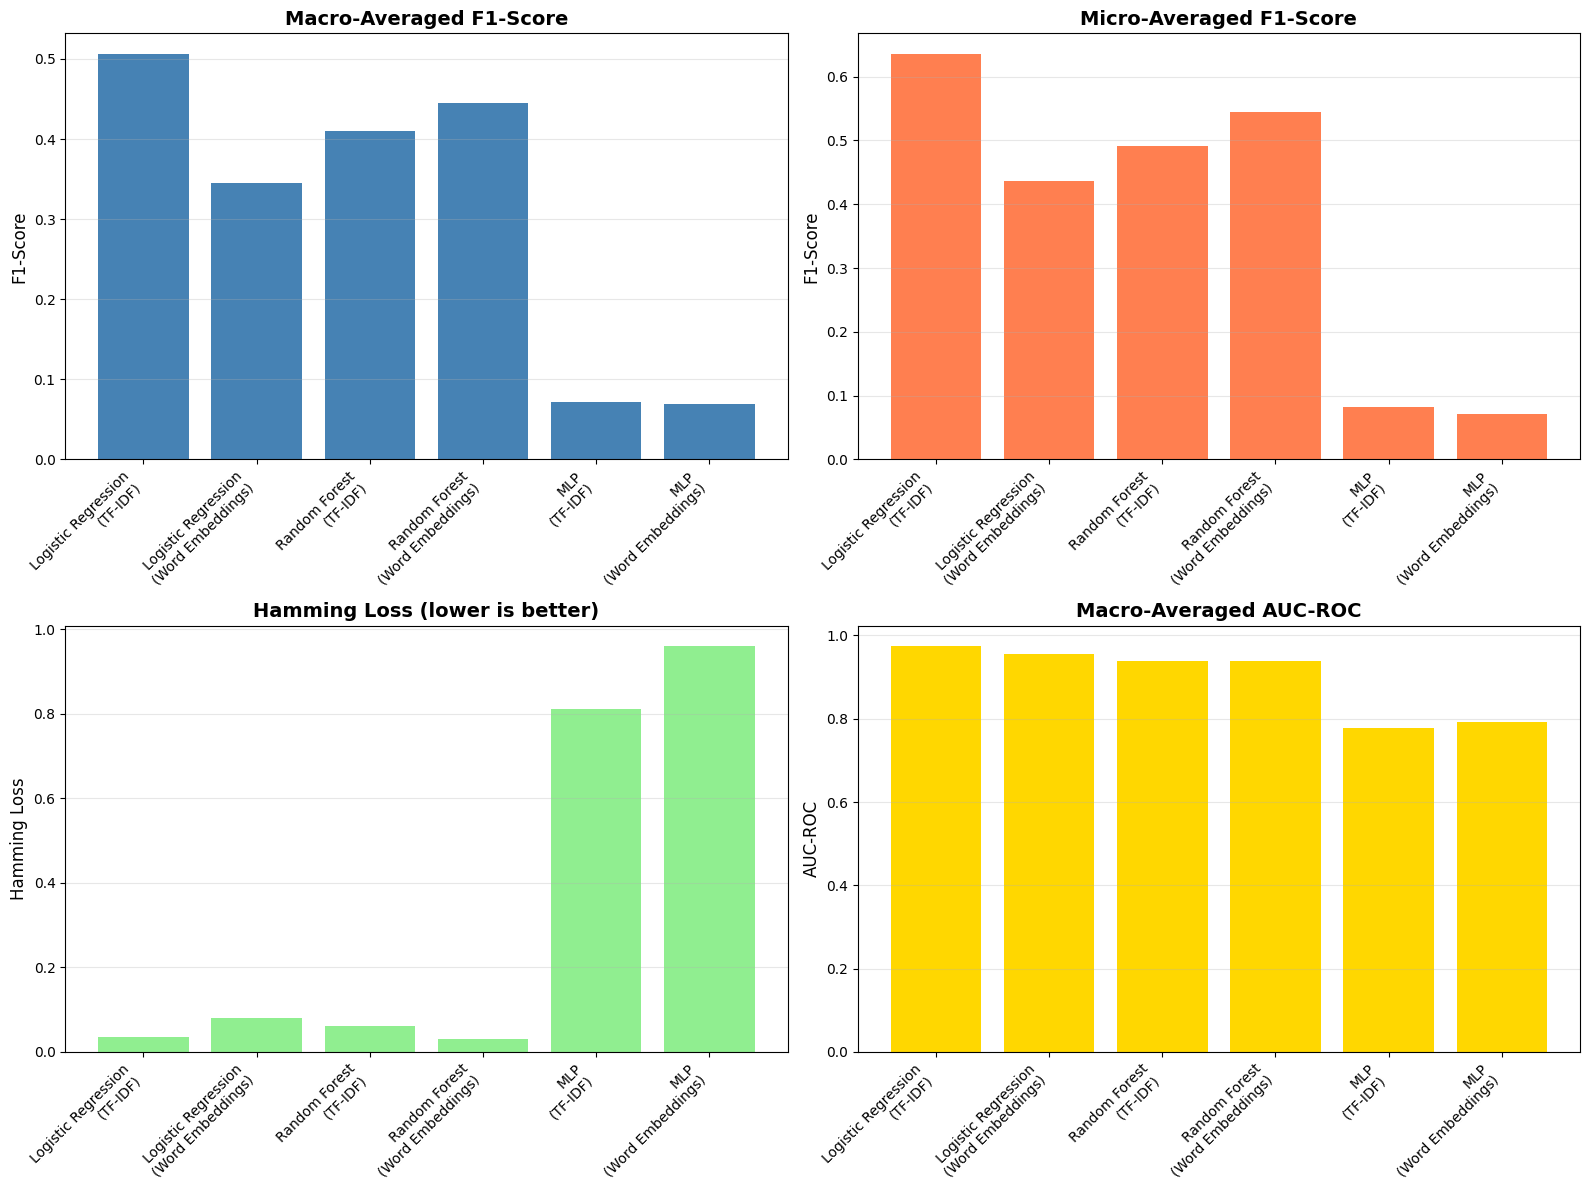

In [39]:
# Visualize overall metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Macro F1 Score
models_labels = [f"{m['Model']}\n({m['Feature_Type']})" for m in all_metrics]
macro_f1_scores = [m['Macro_F1'] for m in all_metrics]
axes[0, 0].bar(range(len(models_labels)), macro_f1_scores, color='steelblue')
axes[0, 0].set_title('Macro-Averaged F1-Score', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('F1-Score', fontsize=12)
axes[0, 0].set_xticks(range(len(models_labels)))
axes[0, 0].set_xticklabels(models_labels, rotation=45, ha='right')
axes[0, 0].grid(axis='y', alpha=0.3)

# Micro F1 Score
micro_f1_scores = [m['Micro_F1'] for m in all_metrics]
axes[0, 1].bar(range(len(models_labels)), micro_f1_scores, color='coral')
axes[0, 1].set_title('Micro-Averaged F1-Score', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_xticks(range(len(models_labels)))
axes[0, 1].set_xticklabels(models_labels, rotation=45, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

# Hamming Loss
hamming_losses = [m['Hamming_Loss'] for m in all_metrics]
axes[1, 0].bar(range(len(models_labels)), hamming_losses, color='lightgreen')
axes[1, 0].set_title('Hamming Loss (lower is better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Hamming Loss', fontsize=12)
axes[1, 0].set_xticks(range(len(models_labels)))
axes[1, 0].set_xticklabels(models_labels, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Macro AUC-ROC
macro_aucs = [m['Macro_AUC'] if m['Macro_AUC'] is not None else 0 for m in all_metrics]
axes[1, 1].bar(range(len(models_labels)), macro_aucs, color='gold')
axes[1, 1].set_title('Macro-Averaged AUC-ROC', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('AUC-ROC', fontsize=12)
axes[1, 1].set_xticks(range(len(models_labels)))
axes[1, 1].set_xticklabels(models_labels, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


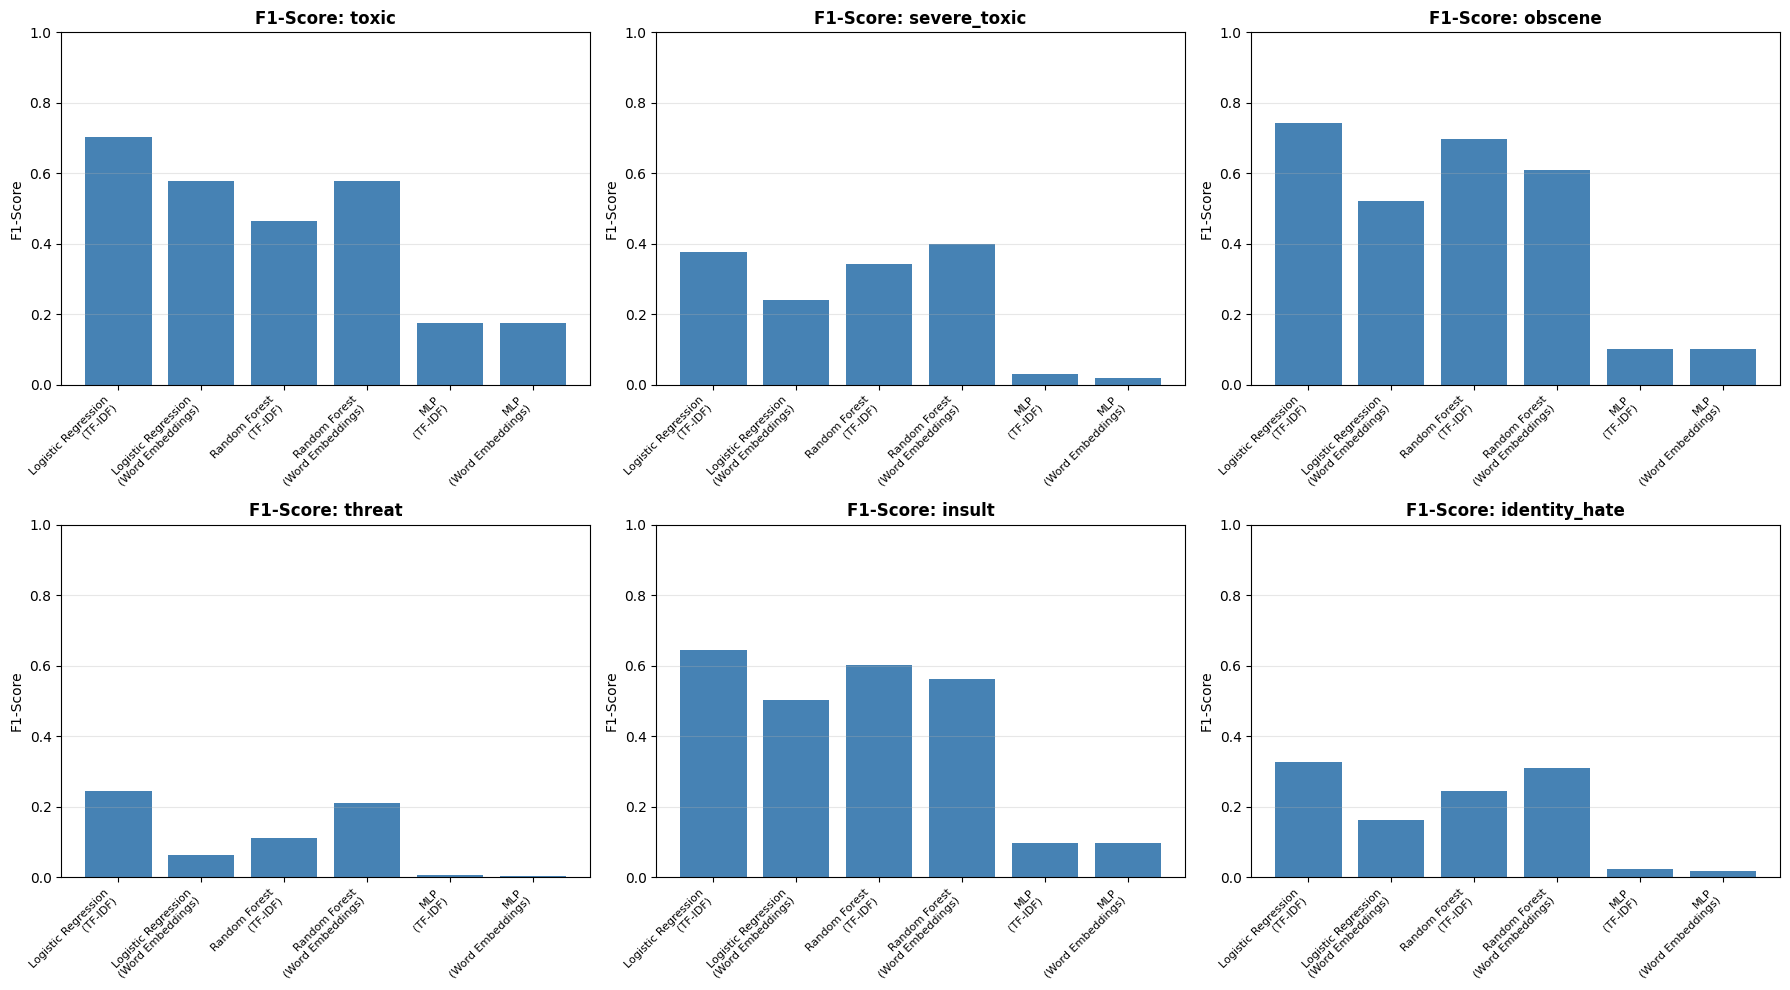

In [40]:
# Per-class F1-Score comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(target_cols):
    f1_scores = [m['Per_Class'][col]['F1-Score'] for m in all_metrics]
    axes[idx].bar(range(len(models_labels)), f1_scores, color='steelblue')
    axes[idx].set_title(f'F1-Score: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('F1-Score', fontsize=10)
    axes[idx].set_xticks(range(len(models_labels)))
    axes[idx].set_xticklabels(models_labels, rotation=45, ha='right', fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()


### 6.4 Confusion Matrices


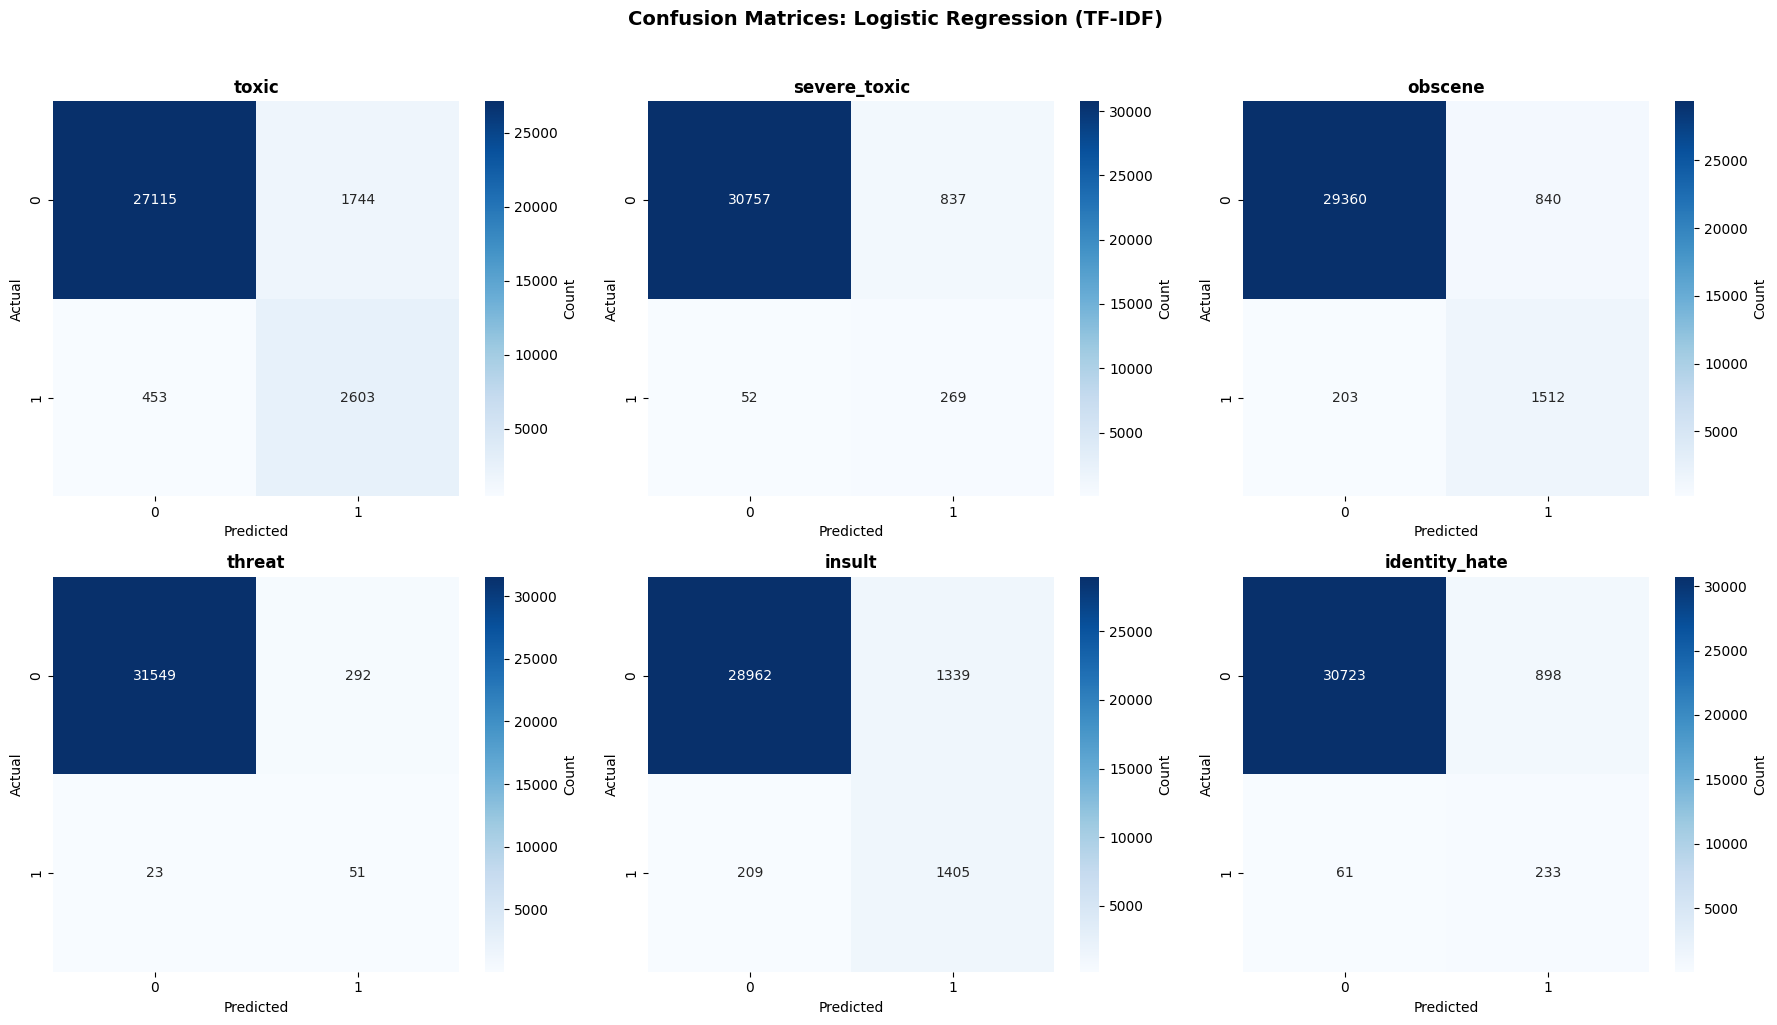

In [41]:
# Confusion matrices for each model 
def plot_confusion_matrices(y_true, y_pred, model_name, feature_type, target_cols):
    """Plot confusion matrices for all classes"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(target_cols):
        cm = confusion_matrix(y_true[col], y_pred[:, idx])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('Actual', fontsize=10)
    
    fig.suptitle(f'Confusion Matrices: {model_name} ({feature_type})', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Plot for Logistic Regression with TF-IDF
plot_confusion_matrices(y_test, y_pred_lr_tfidf, 'Logistic Regression', 'TF-IDF', target_cols)


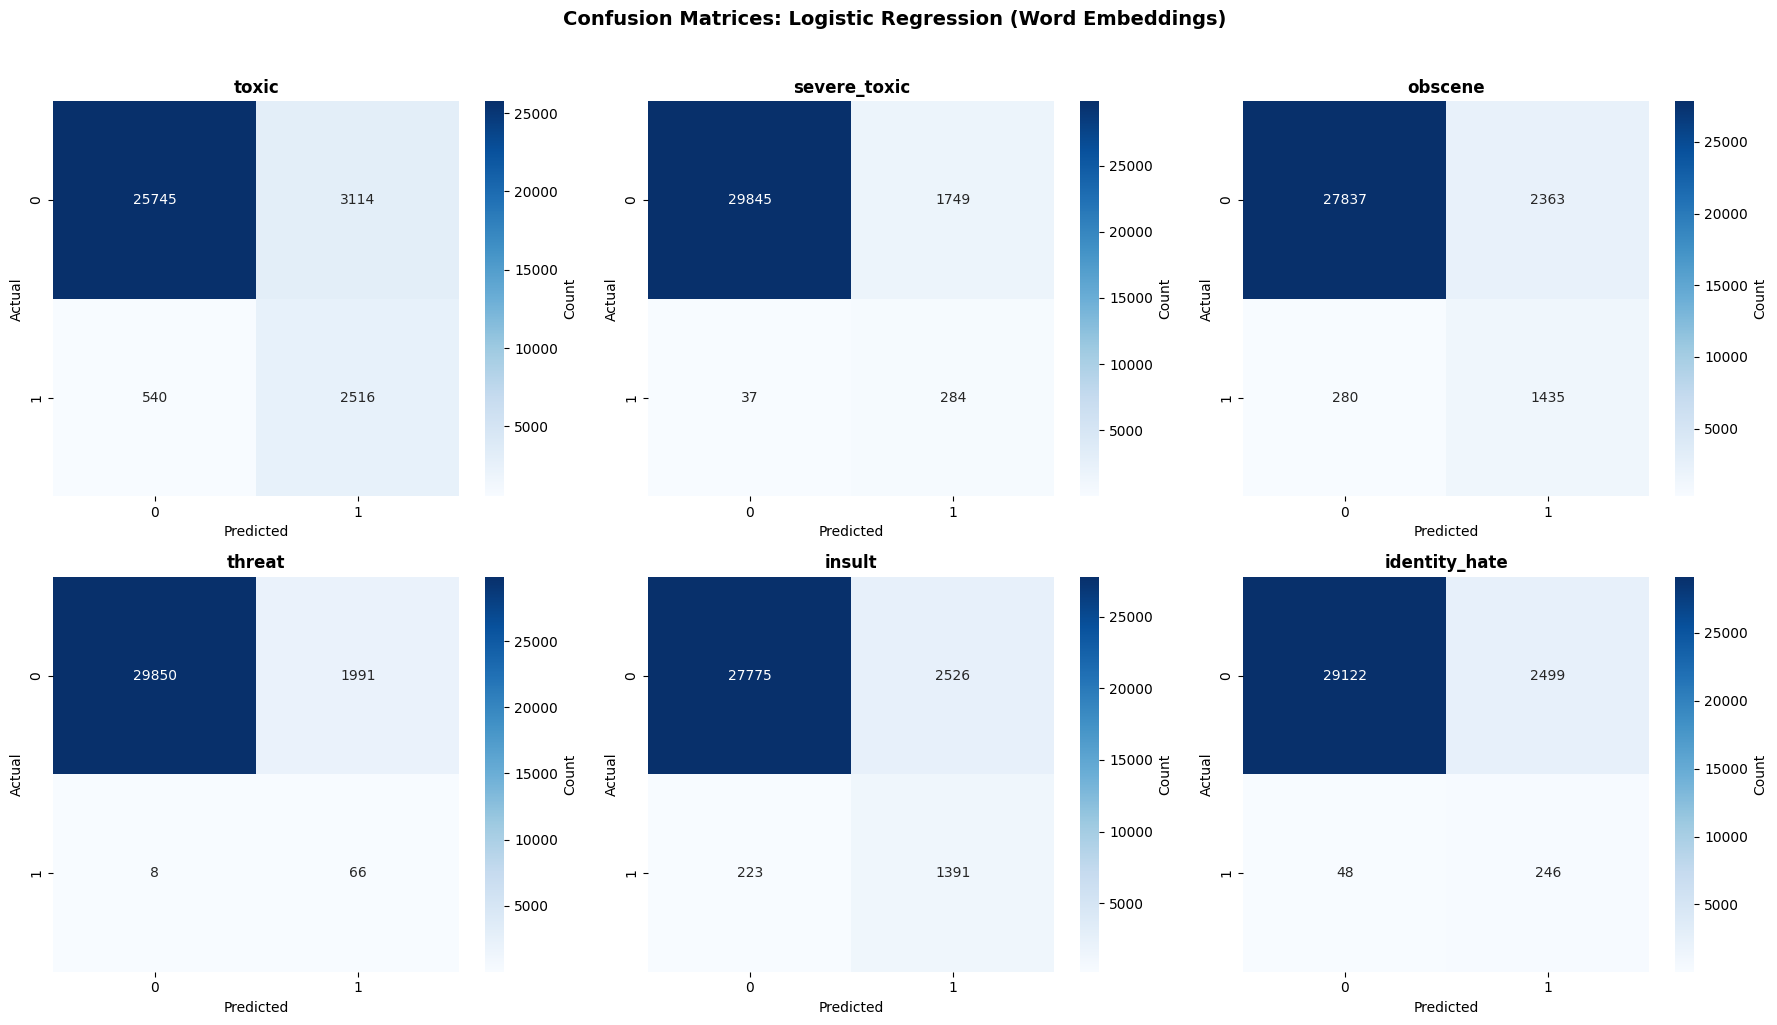

In [42]:
# Plot for Logistic Regression with Embeddings
plot_confusion_matrices(y_test, y_pred_lr_emb, 'Logistic Regression', 'Word Embeddings', target_cols)


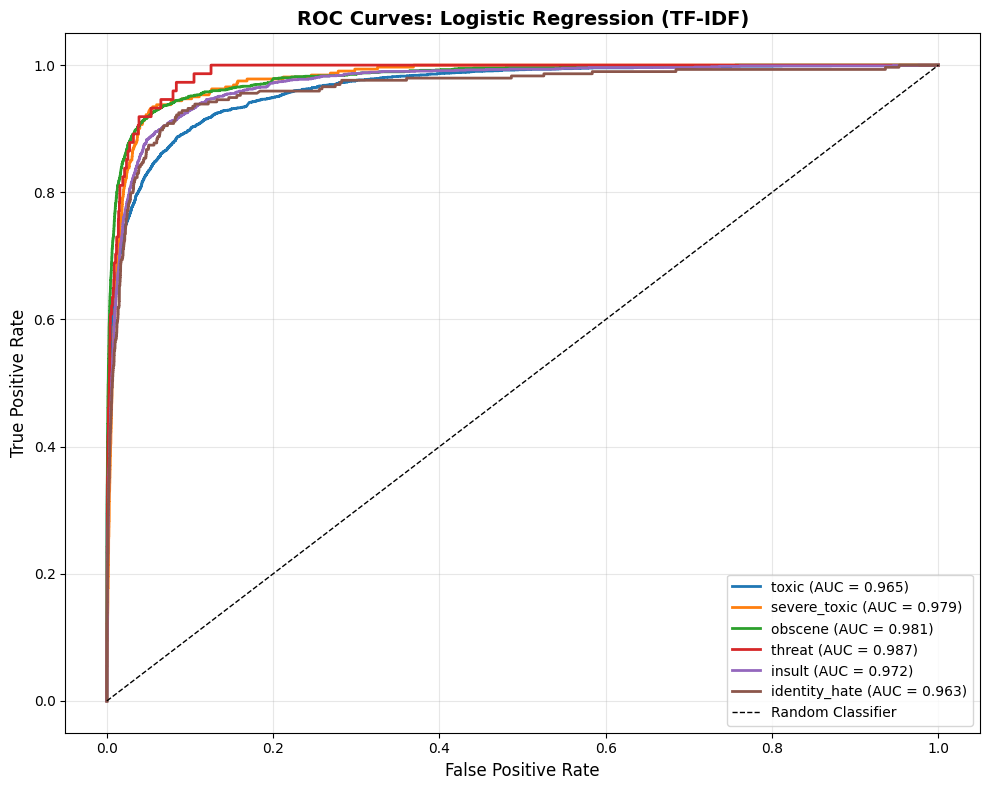

In [43]:
# ROC curves for each model
def plot_roc_curves(y_true, y_pred_proba, model_name, feature_type, target_cols):
    """Plot ROC curves for all classes"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for idx, col in enumerate(target_cols):
        try:
            fpr, tpr, _ = roc_curve(y_true[col], y_pred_proba[:, idx])
            auc_score = roc_auc_score(y_true[col], y_pred_proba[:, idx])
            ax.plot(fpr, tpr, label=f'{col} (AUC = {auc_score:.3f})', linewidth=2)
        except:
            continue
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves: {model_name} ({feature_type})', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ROC curves for Logistic Regression with TF-IDF
plot_roc_curves(y_test, y_pred_proba_lr_tfidf, 'Logistic Regression', 'TF-IDF', target_cols)


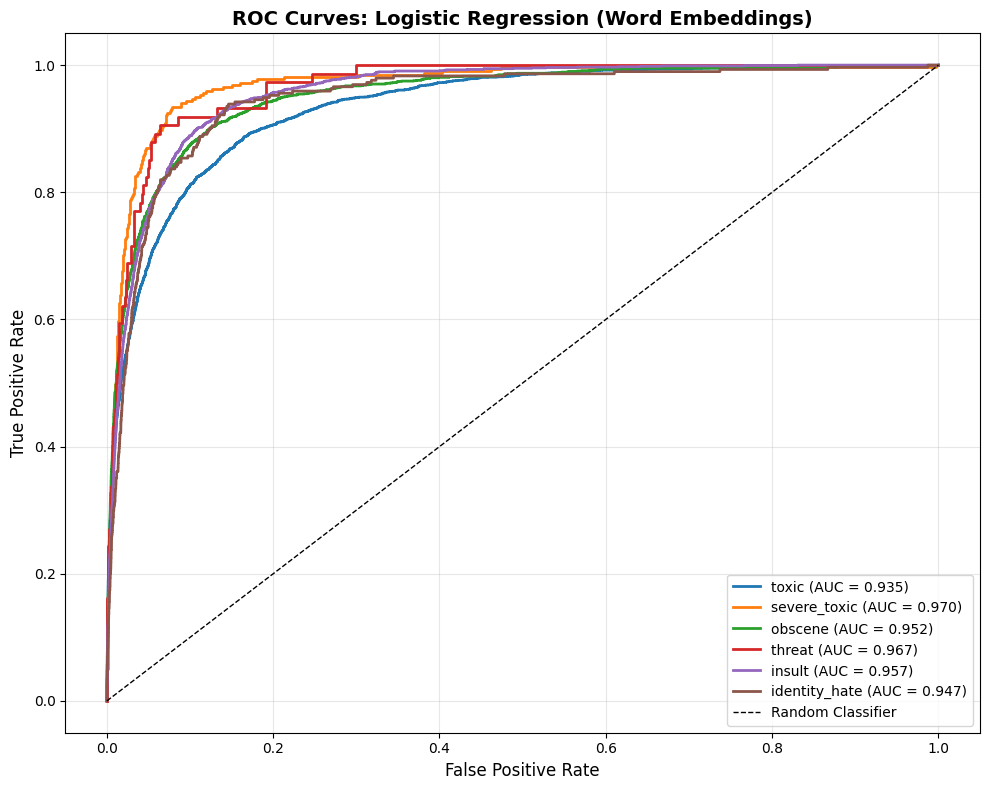

In [44]:
# Plot ROC curves for Logistic Regression with Embeddings
plot_roc_curves(y_test, y_pred_proba_lr_emb, 'Logistic Regression', 'Word Embeddings', target_cols)


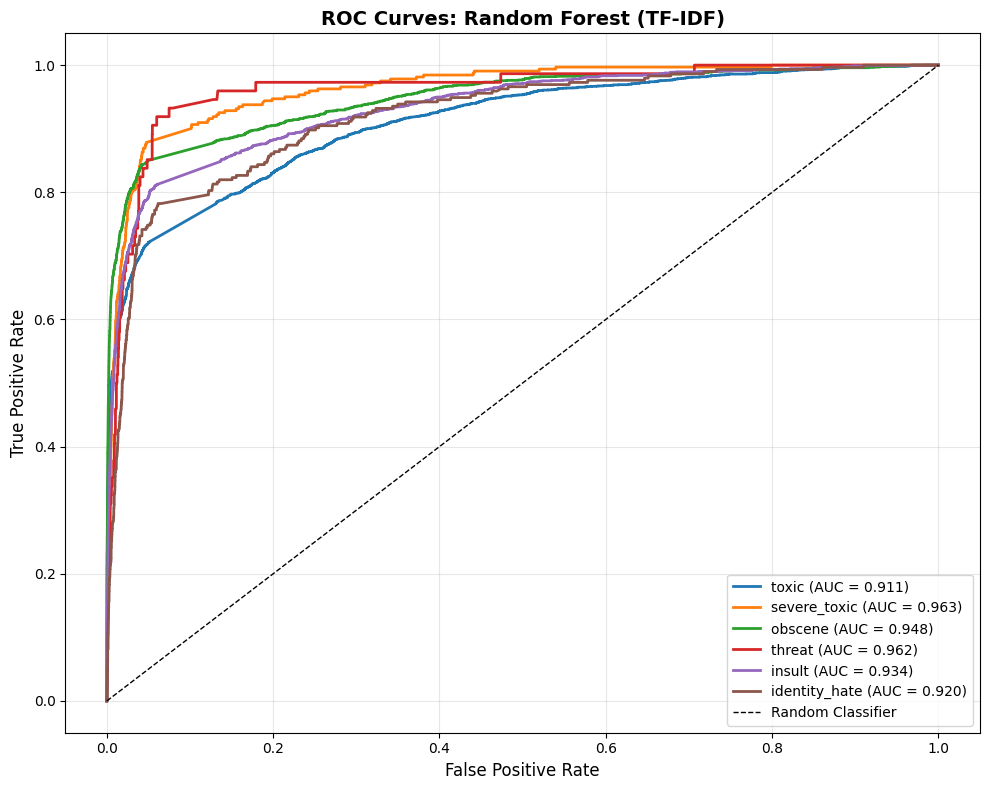

In [45]:
# Plot ROC curves for Random Forest with TF-IDF
plot_roc_curves(y_test, y_pred_proba_rf_tfidf, 'Random Forest', 'TF-IDF', target_cols)


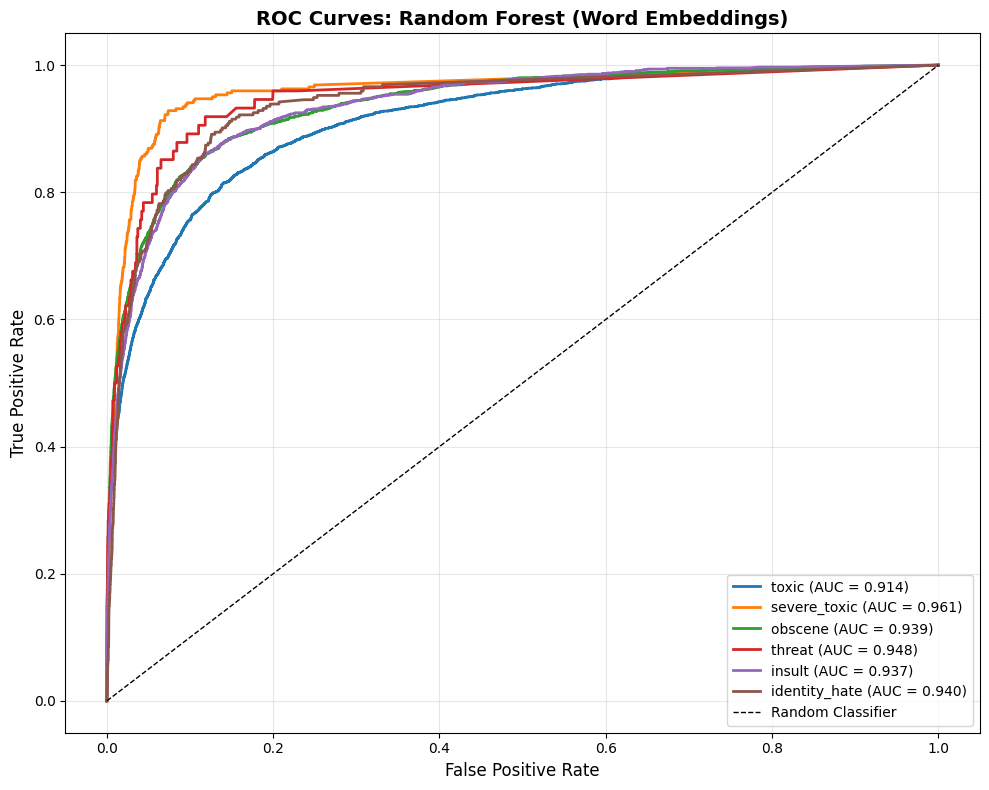

In [46]:
# Plot ROC curves for Random Forest with Embeddings
plot_roc_curves(y_test, y_pred_proba_rf_emb, 'Random Forest', 'Word Embeddings', target_cols)


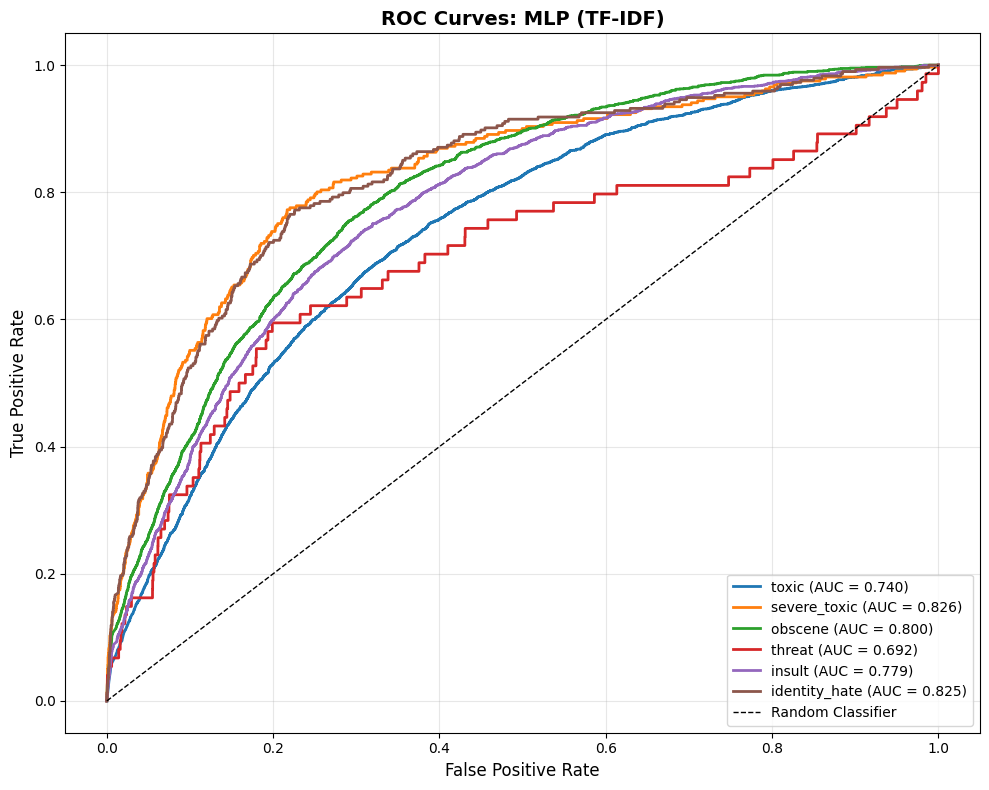

In [47]:
# Plot ROC curves for MLP with TF-IDF
plot_roc_curves(y_test, y_pred_proba_mlp_tfidf, 'MLP', 'TF-IDF', target_cols)


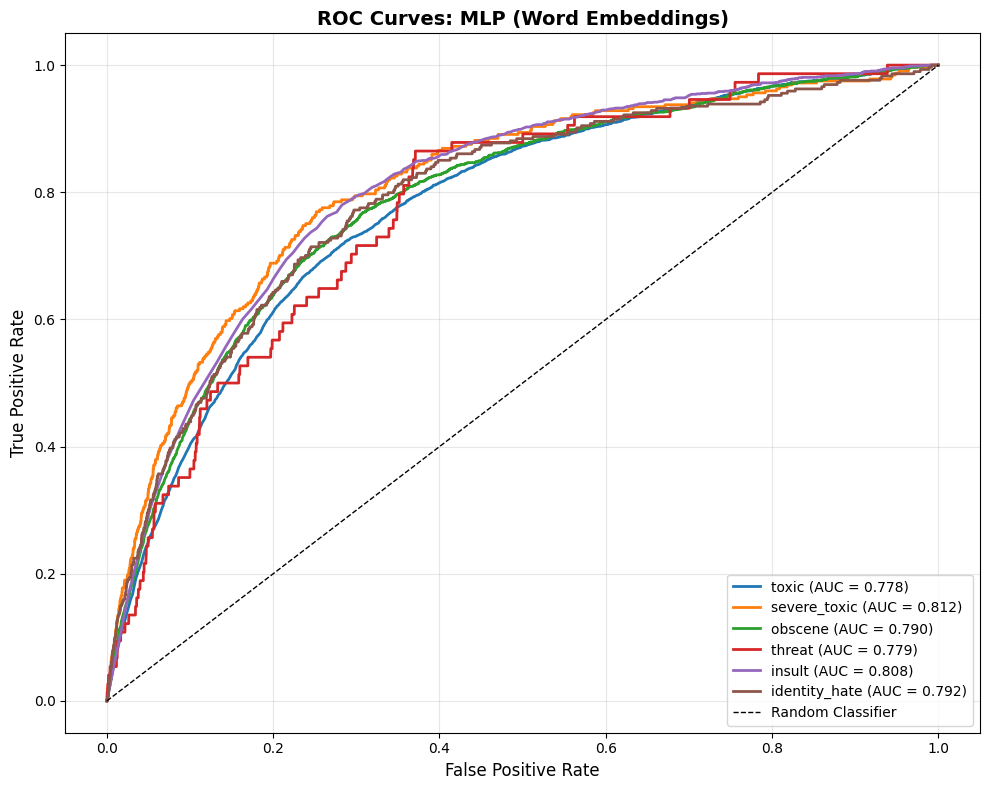

In [48]:
# Plot ROC curves for MLP with Embeddings
plot_roc_curves(y_test, y_pred_proba_mlp_emb, 'MLP', 'Word Embeddings', target_cols)


## 7. Results Comparison and Analysis

### 7.1 Feature Extraction Method Comparison


Feature Extraction Method Comparison:
              Model  TF-IDF Macro F1  Embeddings Macro F1  TF-IDF Micro F1  Embeddings Micro F1  TF-IDF Hamming Loss  Embeddings Hamming Loss  TF-IDF Macro AUC  Embeddings Macro AUC
Logistic Regression         0.506700             0.344671         0.636016             0.435753             0.036300                 0.080307          0.974476              0.954752
      Random Forest         0.410682             0.444969         0.491431             0.544883             0.061058                 0.030263          0.939643              0.939796
                MLP         0.072166             0.069325         0.082895             0.071451             0.811055                 0.960170          0.776825              0.792896


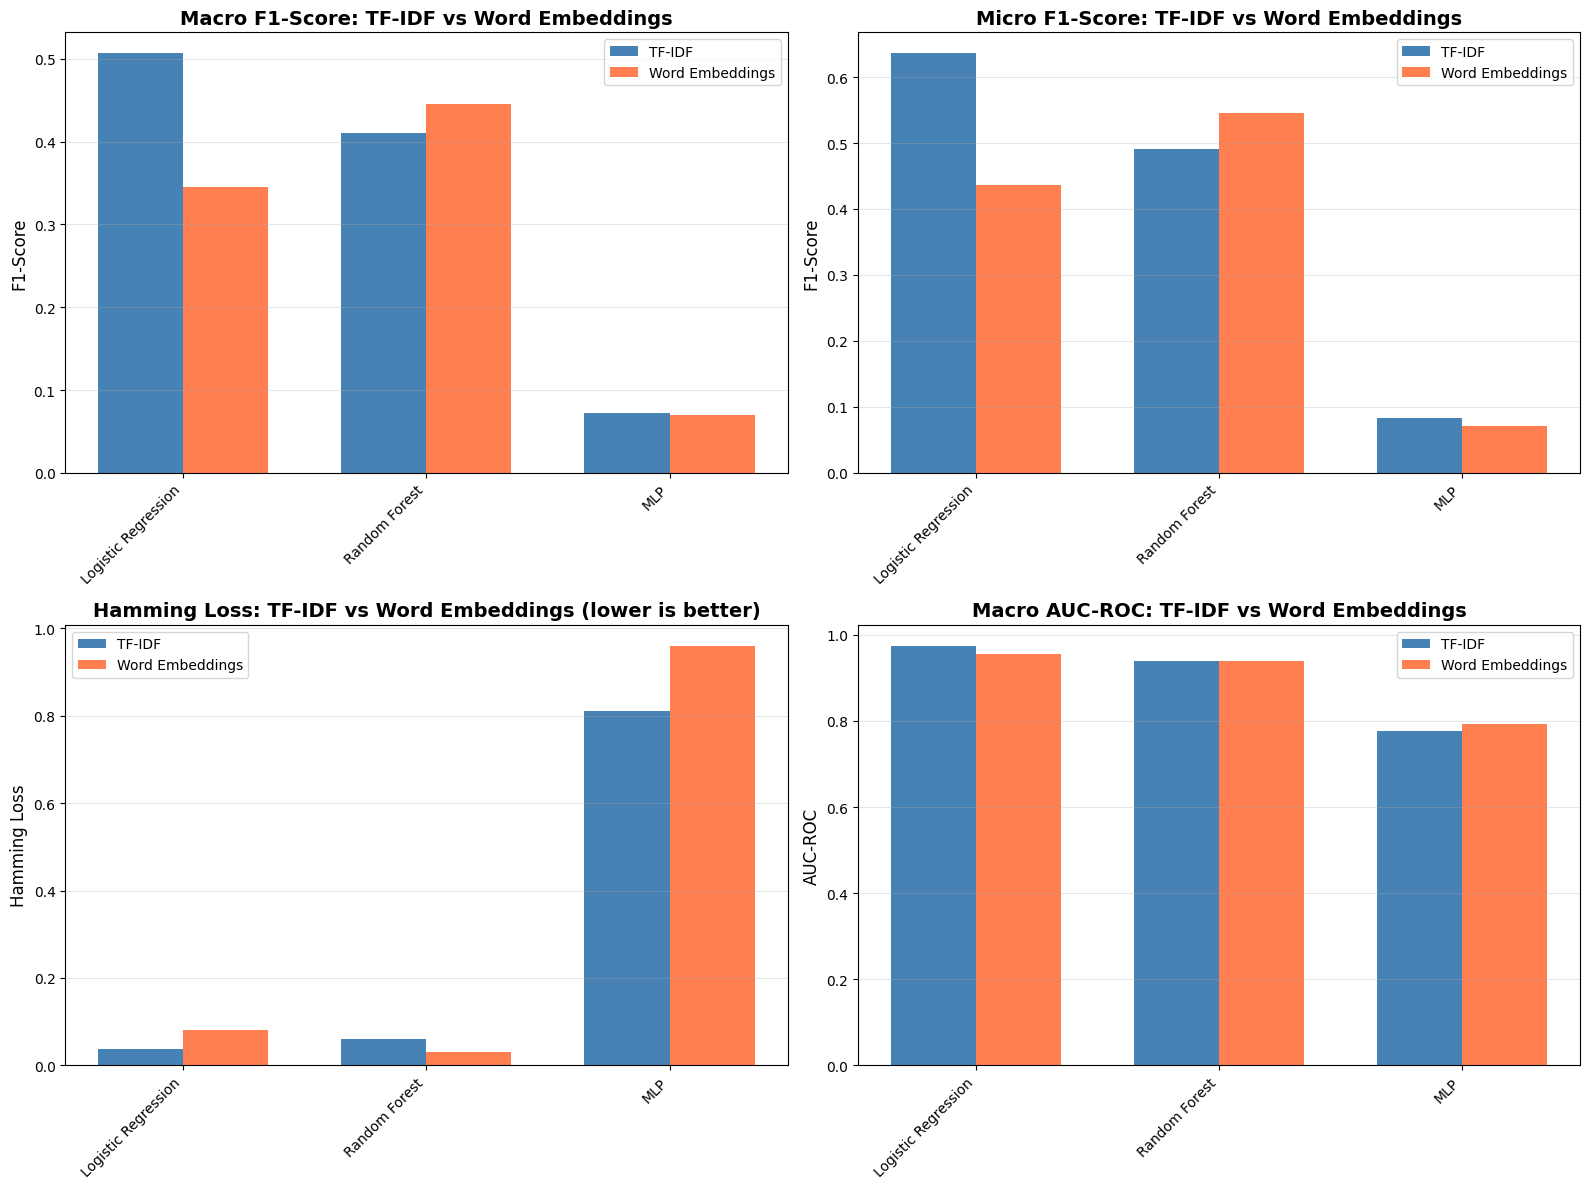

In [49]:
# Compare TF-IDF vs Word Embeddings for each algorithm
comparison_data = []

for model_name in ['Logistic Regression', 'Random Forest', 'MLP']:
    tfidf_metrics = next(m for m in all_metrics if m['Model'] == model_name and m['Feature_Type'] == 'TF-IDF')
    emb_metrics = next(m for m in all_metrics if m['Model'] == model_name and m['Feature_Type'] == 'Word Embeddings')
    
    comparison_data.append({
        'Model': model_name,
        'TF-IDF Macro F1': tfidf_metrics['Macro_F1'],
        'Embeddings Macro F1': emb_metrics['Macro_F1'],
        'TF-IDF Micro F1': tfidf_metrics['Micro_F1'],
        'Embeddings Micro F1': emb_metrics['Micro_F1'],
        'TF-IDF Hamming Loss': tfidf_metrics['Hamming_Loss'],
        'Embeddings Hamming Loss': emb_metrics['Hamming_Loss'],
        'TF-IDF Macro AUC': tfidf_metrics['Macro_AUC'] if tfidf_metrics['Macro_AUC'] else 0,
        'Embeddings Macro AUC': emb_metrics['Macro_AUC'] if emb_metrics['Macro_AUC'] else 0
    })

comparison_df = pd.DataFrame(comparison_data)
print("Feature Extraction Method Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df['Model'].values
x = np.arange(len(models))
width = 0.35

# Macro F1 comparison
axes[0, 0].bar(x - width/2, comparison_df['TF-IDF Macro F1'], width, label='TF-IDF', color='steelblue')
axes[0, 0].bar(x + width/2, comparison_df['Embeddings Macro F1'], width, label='Word Embeddings', color='coral')
axes[0, 0].set_title('Macro F1-Score: TF-IDF vs Word Embeddings', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('F1-Score', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Micro F1 comparison
axes[0, 1].bar(x - width/2, comparison_df['TF-IDF Micro F1'], width, label='TF-IDF', color='steelblue')
axes[0, 1].bar(x + width/2, comparison_df['Embeddings Micro F1'], width, label='Word Embeddings', color='coral')
axes[0, 1].set_title('Micro F1-Score: TF-IDF vs Word Embeddings', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Hamming Loss comparison
axes[1, 0].bar(x - width/2, comparison_df['TF-IDF Hamming Loss'], width, label='TF-IDF', color='steelblue')
axes[1, 0].bar(x + width/2, comparison_df['Embeddings Hamming Loss'], width, label='Word Embeddings', color='coral')
axes[1, 0].set_title('Hamming Loss: TF-IDF vs Word Embeddings (lower is better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Hamming Loss', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Macro AUC comparison
axes[1, 1].bar(x - width/2, comparison_df['TF-IDF Macro AUC'], width, label='TF-IDF', color='steelblue')
axes[1, 1].bar(x + width/2, comparison_df['Embeddings Macro AUC'], width, label='Word Embeddings', color='coral')
axes[1, 1].set_title('Macro AUC-ROC: TF-IDF vs Word Embeddings', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('AUC-ROC', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 7.2 Algorithm Comparison


Algorithm Comparison with TF-IDF:
              Model  Macro F1  Micro F1  Hamming Loss  Macro AUC
Logistic Regression  0.506700  0.636016      0.036300   0.974476
      Random Forest  0.410682  0.491431      0.061058   0.939643
                MLP  0.072166  0.082895      0.811055   0.776825

Algorithm Comparison with Word Embeddings:
              Model  Macro F1  Micro F1  Hamming Loss  Macro AUC
Logistic Regression  0.344671  0.435753      0.080307   0.954752
      Random Forest  0.444969  0.544883      0.030263   0.939796
                MLP  0.069325  0.071451      0.960170   0.792896


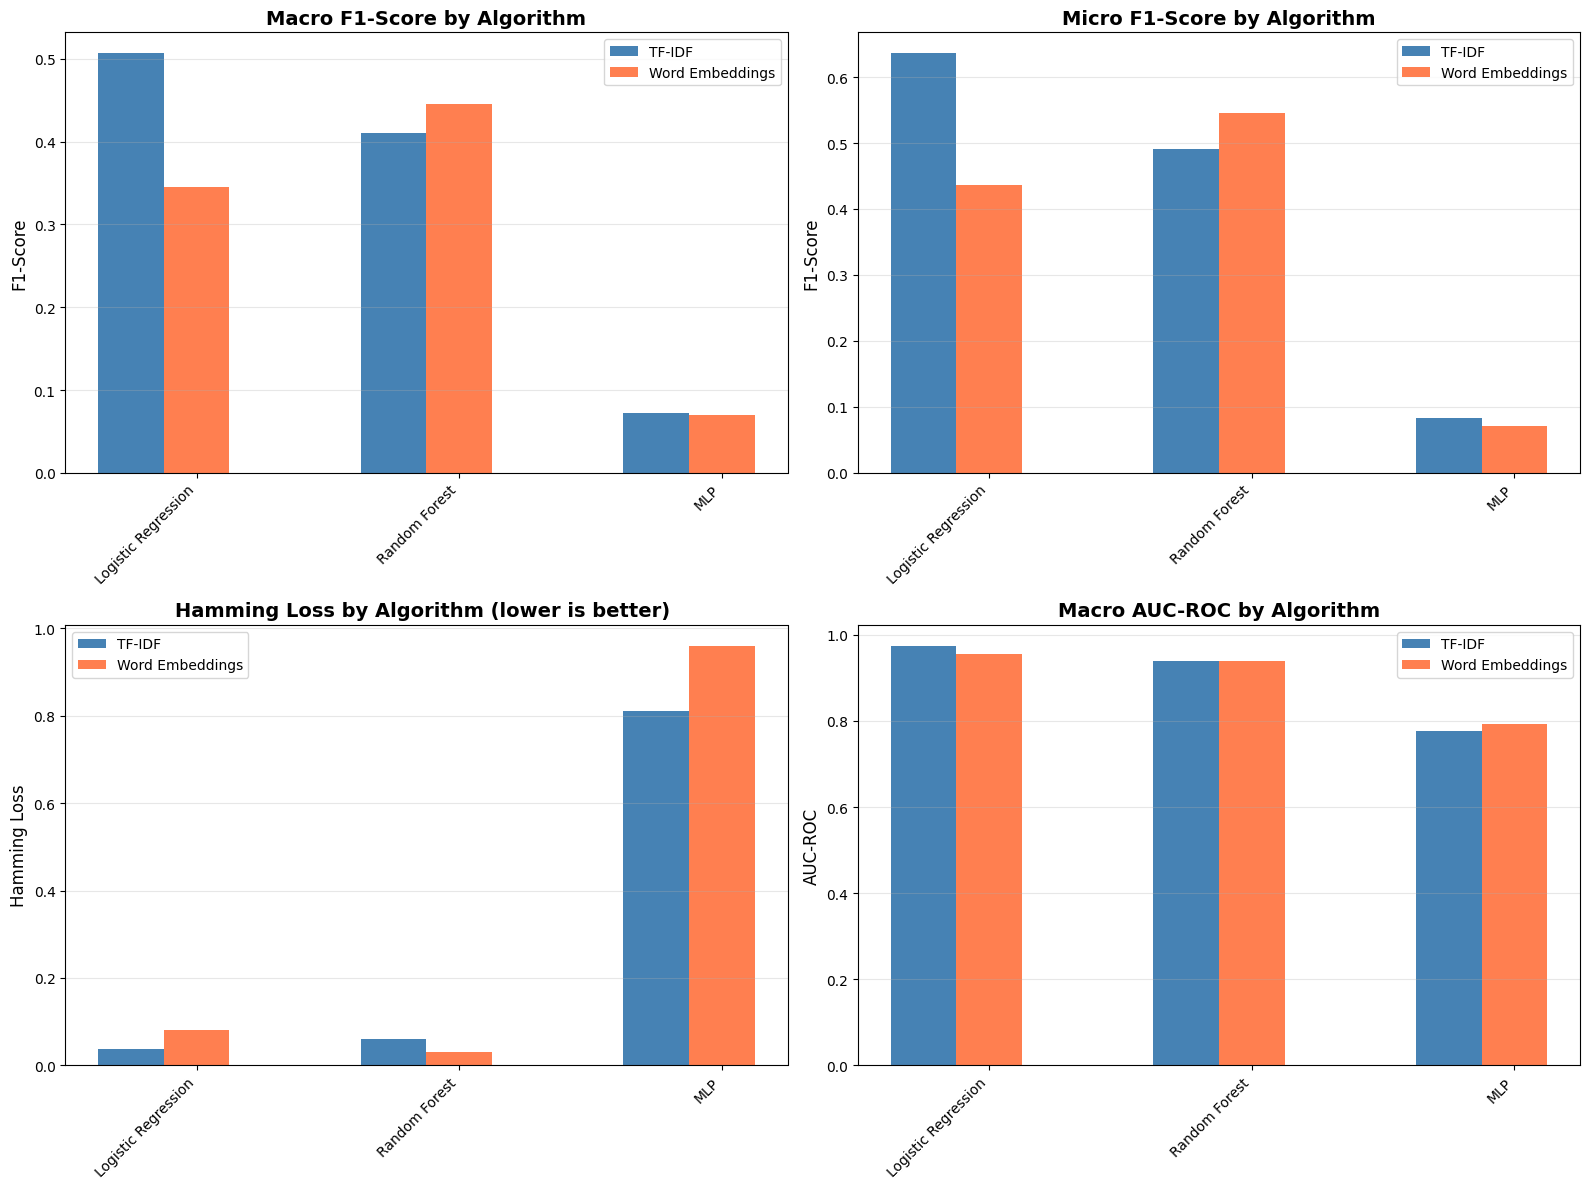

In [50]:
# Compare algorithms within each feature extraction method
algo_comparison_tfidf = []
algo_comparison_emb = []

for model_name in ['Logistic Regression', 'Random Forest', 'MLP']:
    tfidf_metrics = next(m for m in all_metrics if m['Model'] == model_name and m['Feature_Type'] == 'TF-IDF')
    emb_metrics = next(m for m in all_metrics if m['Model'] == model_name and m['Feature_Type'] == 'Word Embeddings')
    
    algo_comparison_tfidf.append({
        'Model': model_name,
        'Macro F1': tfidf_metrics['Macro_F1'],
        'Micro F1': tfidf_metrics['Micro_F1'],
        'Hamming Loss': tfidf_metrics['Hamming_Loss'],
        'Macro AUC': tfidf_metrics['Macro_AUC'] if tfidf_metrics['Macro_AUC'] else 0
    })
    
    algo_comparison_emb.append({
        'Model': model_name,
        'Macro F1': emb_metrics['Macro_F1'],
        'Micro F1': emb_metrics['Micro_F1'],
        'Hamming Loss': emb_metrics['Hamming_Loss'],
        'Macro AUC': emb_metrics['Macro_AUC'] if emb_metrics['Macro_AUC'] else 0
    })

algo_tfidf_df = pd.DataFrame(algo_comparison_tfidf)
algo_emb_df = pd.DataFrame(algo_comparison_emb)

print("Algorithm Comparison with TF-IDF:")
print(algo_tfidf_df.to_string(index=False))
print("\nAlgorithm Comparison with Word Embeddings:")
print(algo_emb_df.to_string(index=False))

# Visualize algorithm comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = algo_tfidf_df['Model'].values
x = np.arange(len(models))
width = 0.25

# Macro F1 - both feature types
axes[0, 0].bar(x - width, algo_tfidf_df['Macro F1'], width, label='TF-IDF', color='steelblue')
axes[0, 0].bar(x, algo_emb_df['Macro F1'], width, label='Word Embeddings', color='coral')
axes[0, 0].set_title('Macro F1-Score by Algorithm', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('F1-Score', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Micro F1 - both feature types
axes[0, 1].bar(x - width, algo_tfidf_df['Micro F1'], width, label='TF-IDF', color='steelblue')
axes[0, 1].bar(x, algo_emb_df['Micro F1'], width, label='Word Embeddings', color='coral')
axes[0, 1].set_title('Micro F1-Score by Algorithm', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Hamming Loss -both feature types
axes[1, 0].bar(x - width, algo_tfidf_df['Hamming Loss'], width, label='TF-IDF', color='steelblue')
axes[1, 0].bar(x, algo_emb_df['Hamming Loss'], width, label='Word Embeddings', color='coral')
axes[1, 0].set_title('Hamming Loss by Algorithm (lower is better) ', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Hamming Loss', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Macro AUC - both feature types
axes[1, 1].bar(x - width, algo_tfidf_df['Macro AUC'], width, label='TF-IDF', color='steelblue')
axes[1, 1].bar(x, algo_emb_df['Macro AUC'], width, label='Word Embeddings', color='coral')
axes[1, 1].set_title('Macro AUC-ROC by Algorithm', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('AUC-ROC', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [51]:
# Find best performing model based on different metrics
best_models = {
    'Best Macro F1': max(all_metrics, key=lambda x: x['Macro_F1']),
    'Best Micro F1': max(all_metrics, key=lambda x: x['Micro_F1']),
    'Best Hamming Loss': min(all_metrics, key=lambda x: x['Hamming_Loss']),
    'Best Macro AUC': max(all_metrics, key=lambda x: x['Macro_AUC'] if x['Macro_AUC'] is not None else 0)
}

print("Best Performing Models:")
print("=" * 80)
for metric_name, best_model in best_models.items():
    print(f"\n{metric_name}:")
    print(f"  Model: {best_model['Model']}")
    print(f"  Feature Type: {best_model['Feature_Type']}")
    if metric_name == 'Best Macro F1':
        print(f"  Score: {best_model['Macro_F1']:.4f}")
    elif metric_name == 'Best Micro F1':
        print(f"  Score: {best_model['Micro_F1']:.4f}")
    elif metric_name == 'Best Hamming Loss':
        print(f"  Score: {best_model['Hamming_Loss']:.4f}")
    elif metric_name == 'Best Macro AUC':
        print(f"  Score: {best_model['Macro_AUC']:.4f}" if best_model['Macro_AUC'] else "  Score: N/A")


Best Performing Models:

Best Macro F1:
  Model: Logistic Regression
  Feature Type: TF-IDF
  Score: 0.5067

Best Micro F1:
  Model: Logistic Regression
  Feature Type: TF-IDF
  Score: 0.6360

Best Hamming Loss:
  Model: Random Forest
  Feature Type: Word Embeddings
  Score: 0.0303

Best Macro AUC:
  Model: Logistic Regression
  Feature Type: TF-IDF
  Score: 0.9745


## 9. Save Best Model for Inference


In [52]:
# import additional libraries for model saving
import joblib
import os
import json
from datetime import datetime

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Select best model based on Macro F1 score (primary metric for multi-label classification)
best_model_metric = best_models['Best Macro F1']
best_model_name = best_model_metric['Model']
best_feature_type = best_model_metric['Feature_Type']

print(f"Selected best model: {best_model_name} with {best_feature_type}")
print(f"Macro F1 Score: {best_model_metric['Macro_F1']:.4f}")
print(f"Micro F1 Score: {best_model_metric['Micro_F1']:.4f}")
print(f"Macro AUC: {best_model_metric['Macro_AUC']:.4f}" if best_model_metric['Macro_AUC'] else "Macro AUC: N/A")

# Map model names to actual model objects
model_mapping = {
    ('Logistic Regression', 'TF-IDF'): lr_tfidf,
    ('Logistic Regression', 'Word Embeddings'): lr_emb,
    ('Random Forest', 'TF-IDF'): rf_tfidf,
    ('Random Forest', 'Word Embeddings'): rf_emb,
    ('MLP', 'TF-IDF'): mlp_tfidf,
    ('MLP', 'Word Embeddings'): mlp_emb
}

# Get the best model
best_model = model_mapping[(best_model_name, best_feature_type)]

# Save the model
model_filename_base = f"best_model_{best_model_name.lower().replace(' ', '_')}_{best_feature_type.lower().replace('-', '_')}.pkl"
model_filename_full = f"models/{model_filename_base}"
joblib.dump(best_model, model_filename_full)
print(f"\nModel saved to: {model_filename_full}")

# Save TF-IDF vectorizer if the best model uses TF-IDF
vectorizer_filename_base = None
if best_feature_type == 'TF-IDF':
    vectorizer_filename_base = "tfidf_vectorizer.pkl"
    vectorizer_filename_full = f"models/{vectorizer_filename_base}"
    joblib.dump(tfidf_vectorizer, vectorizer_filename_full)
    print(f"TF-IDF vectorizer saved to: {vectorizer_filename_full}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'feature_type': best_feature_type,
    'algorithm': best_model_name,
    'target_columns': target_cols,
    'metrics': {
        'macro_f1': float(best_model_metric['Macro_F1']),
        'micro_f1': float(best_model_metric['Micro_F1']),
        'hamming_loss': float(best_model_metric['Hamming_Loss']),
        'macro_auc': float(best_model_metric['Macro_AUC']) if best_model_metric['Macro_AUC'] else None
    },
    'per_class_metrics': {
        col: {
            'accuracy': float(best_model_metric['Per_Class'][col]['Accuracy']),
            'precision': float(best_model_metric['Per_Class'][col]['Precision']),
            'recall': float(best_model_metric['Per_Class'][col]['Recall']),
            'f1_score': float(best_model_metric['Per_Class'][col]['F1-Score']),
            'auc_roc': float(best_model_metric['Per_Class'][col]['AUC-ROC']) if best_model_metric['Per_Class'][col]['AUC-ROC'] else None
        }
        for col in target_cols
    },
    'saved_at': datetime.now().isoformat(),
    'model_file': model_filename_base,  # Store just filename, not full path
    'vectorizer_file': vectorizer_filename_base if best_feature_type == 'TF-IDF' else None
}

metadata_filename = "models/model_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Model metadata saved to: {metadata_filename}")

print("Model saving completed successfully!")

Selected best model: Logistic Regression with TF-IDF
Macro F1 Score: 0.5067
Micro F1 Score: 0.6360
Macro AUC: 0.9745

Model saved to: models/best_model_logistic_regression_tf_idf.pkl
TF-IDF vectorizer saved to: models/tfidf_vectorizer.pkl
Model metadata saved to: models/model_metadata.json
Model saving completed successfully!


## 8. Conclusions and Observations

### 8.1 Key Findings


### Dataset Characteristics:
1. **Class Imbalance**: The dataset is highly imbalanced with neutral comments dominating (~90%). This requires careful handling through class weights or sampling techniques.

2. **Multi-label Nature**: Comments can have multiple toxicity labels simultaneously, requiring multi-label classification approaches.

3. **Token Distribution**: Different classes show varying average token counts, which may impact model performance.

### Feature Extraction Comparison:
- **TF-IDF**: Captures term frequency and importance, good for identifying specific toxic terms
- **Word Embeddings**: Captures semantic relationships, may generalize better to unseen toxic patterns

### ML Models Comparison:
Logistic Regression with TF-IDF is the best-performing configuration. It achieves the highest macro F1-score while maintaining strong micro F1, low Hamming loss and high macro AUC-ROC, and re-mains computationally efficient and interpretable. Macro F1 was chosen as the main selection metric because it gives equal weight to all labels and is therefore appropriate under severe class imbalance. TF-IDF features proved more effective than embeddings for Logistic Regression, as frequency-based n-gram patterns capture toxic terminology well. Balanced class weights helped mitigate imbalance, enabling good performance on majority classes (e.g. obscene, toxic, insult) while still providing rea-sonable performance on rare labels.


### Recommendations
Although the selected model performs well, rare classes such as threat and identity_hate remain challenging. Techniques focused on class imbalance, such as SMOTE or focal loss, could improve the precision–recall trade-off for these labels. In future work, transformer-based models such as BERT may further enhance performance by capturing richer contextual information, particularly for subtle or infrequent forms of toxicity.
